# Tutorial on visualization of Neural Networks

This exercise aims at exploring different ways of visualizing Neural Networks:
- t-SNE of representations (CIFAR10)
- grad-CAM (ImageNet)
- activation maximization (ImageNet)

First, some preliminaries that facilitate plotting and data access on Google drive ... just execute !

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%load_ext autoreload
%autoreload 2

import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive')

#%cd /content/gdrive/My\ Drive/Colab\ Notebooks/dlia_course/practical_sessions/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# basic imports
import os
import time

# import keras and tensorflow classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# check the hardware settings
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# use GPU as hardware acceleration.
tf.device('/device:GPU:0')

# Visualization of the encodings by t-SNE

First, we will visualize encodings of a network trained on the CIFAR data set. Here, we import and preprocess the data. We keep the original labels in `y_data` (to be used for visualization later on). For training, we need to transform them to one-hot-vectors.

In [3]:
from tensorflow.keras.datasets import cifar10

(x_data, y_data), (x_test, y_test) = cifar10.load_data()


**Assignment**: To use as input to our classification model, we need to preprocess the data:


*   Convert x to float and normalize values to [0, 1]
*   Convert y to one-hot vectors, using to_categorical from tensorflow.keras.utils
* Split train/val data by taking first 40000 images for training and the rest for validation



In [4]:
from tensorflow.keras.utils import to_categorical

# preprocessing (normalization)
x_data = x_data.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# encodings in one-hot-vectors
y_train_cat = to_categorical(y_data, num_classes = 10)
y_test_cat =  to_categorical(y_test, num_classes = 10)

# train/val separation
x_train = x_data[:40000]
x_val = x_data[40000:]
y_train = y_train_cat[:40000]
y_val = y_train_cat[40000:]

We will first visualize the data.

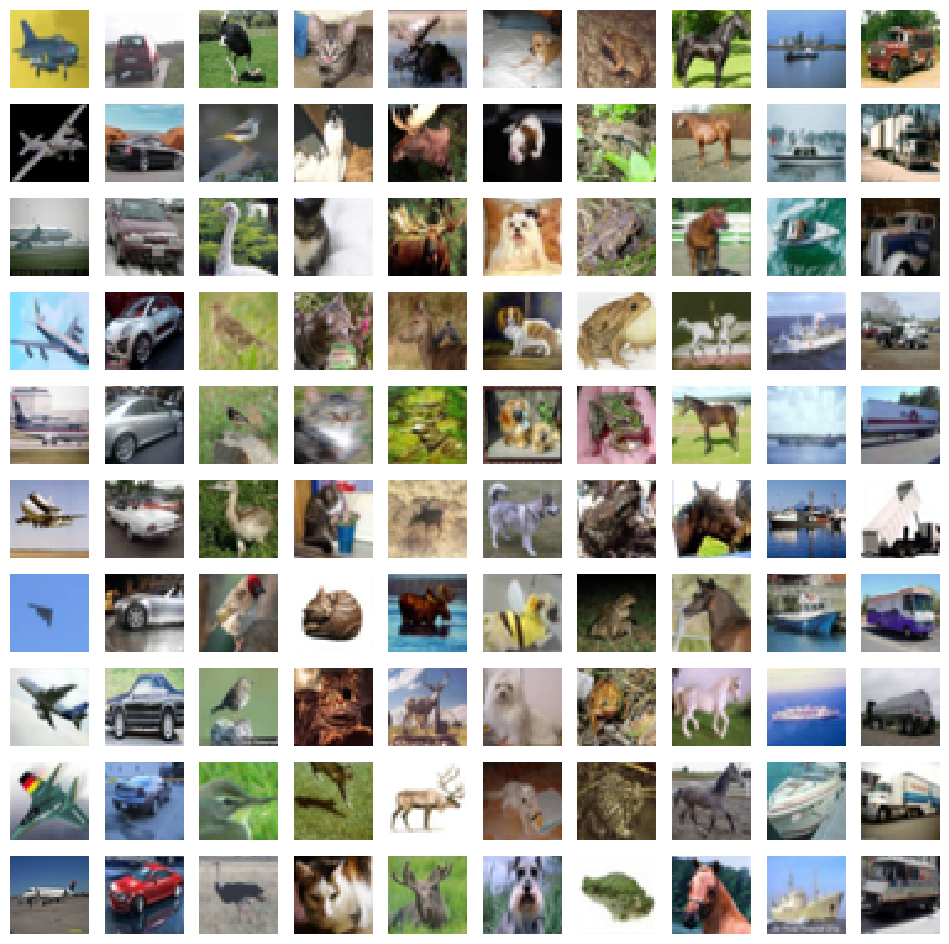

In [5]:
# helper function to plot a few images for each class
def plot_array(fig, X, Y, classes_to_plot=None, samples_per_class=7):
    if classes_to_plot is None:
        classes_to_plot = np.unique(Y)
    num_classes = len(classes_to_plot)

    for k, y in enumerate(classes_to_plot):
        idxs = np.flatnonzero(Y == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        #print(y, idxs)

        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + k + 1
            ax = fig.add_subplot(samples_per_class, num_classes, plt_idx)
            ax.imshow(X[idx].astype(np.uint8))
            ax.axis('off')
fig = plt.figure(figsize=(12, 12))
plot_array(fig, x_data*255, y_data, samples_per_class=10)

Next we define a neural network and train it on the data set. We output the model summary. The model summary gives you also the names of each of the layers.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

Now, we train the neural network, we observe training and validation error, and we try to get a solution that roughly obtains 75\% or more on the test set.

In [7]:
# model fit
history = model.fit(x_train, y_train, epochs=10, batch_size=64,
                    validation_data=(x_val, y_val))

model.evaluate(x=x_test, y=y_test_cat)

Epoch 1/10
625/625 [==============================] - 16s 12ms/step - loss: 1.7931 - accuracy: 0.3484 - val_loss: 1.3368 - val_accuracy: 0.5107
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 1.2977 - accuracy: 0.5373 - val_loss: 1.0757 - val_accuracy: 0.6197
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 1.0495 - accuracy: 0.6304 - val_loss: 0.9201 - val_accuracy: 0.6750
Epoch 4/10
625/625 [==============================] - 7s 12ms/step - loss: 0.9086 - accuracy: 0.6811 - val_loss: 0.7753 - val_accuracy: 0.7324
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.8200 - accuracy: 0.7121 - val_loss: 0.7372 - val_accuracy: 0.7460
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.7532 - accuracy: 0.7387 - val_loss: 0.7162 - val_accuracy: 0.7563
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.7000 - accuracy: 0.7580 - val_loss: 0.6934 - val_accuracy: 0.7643

[0.7119780778884888, 0.7720999717712402]

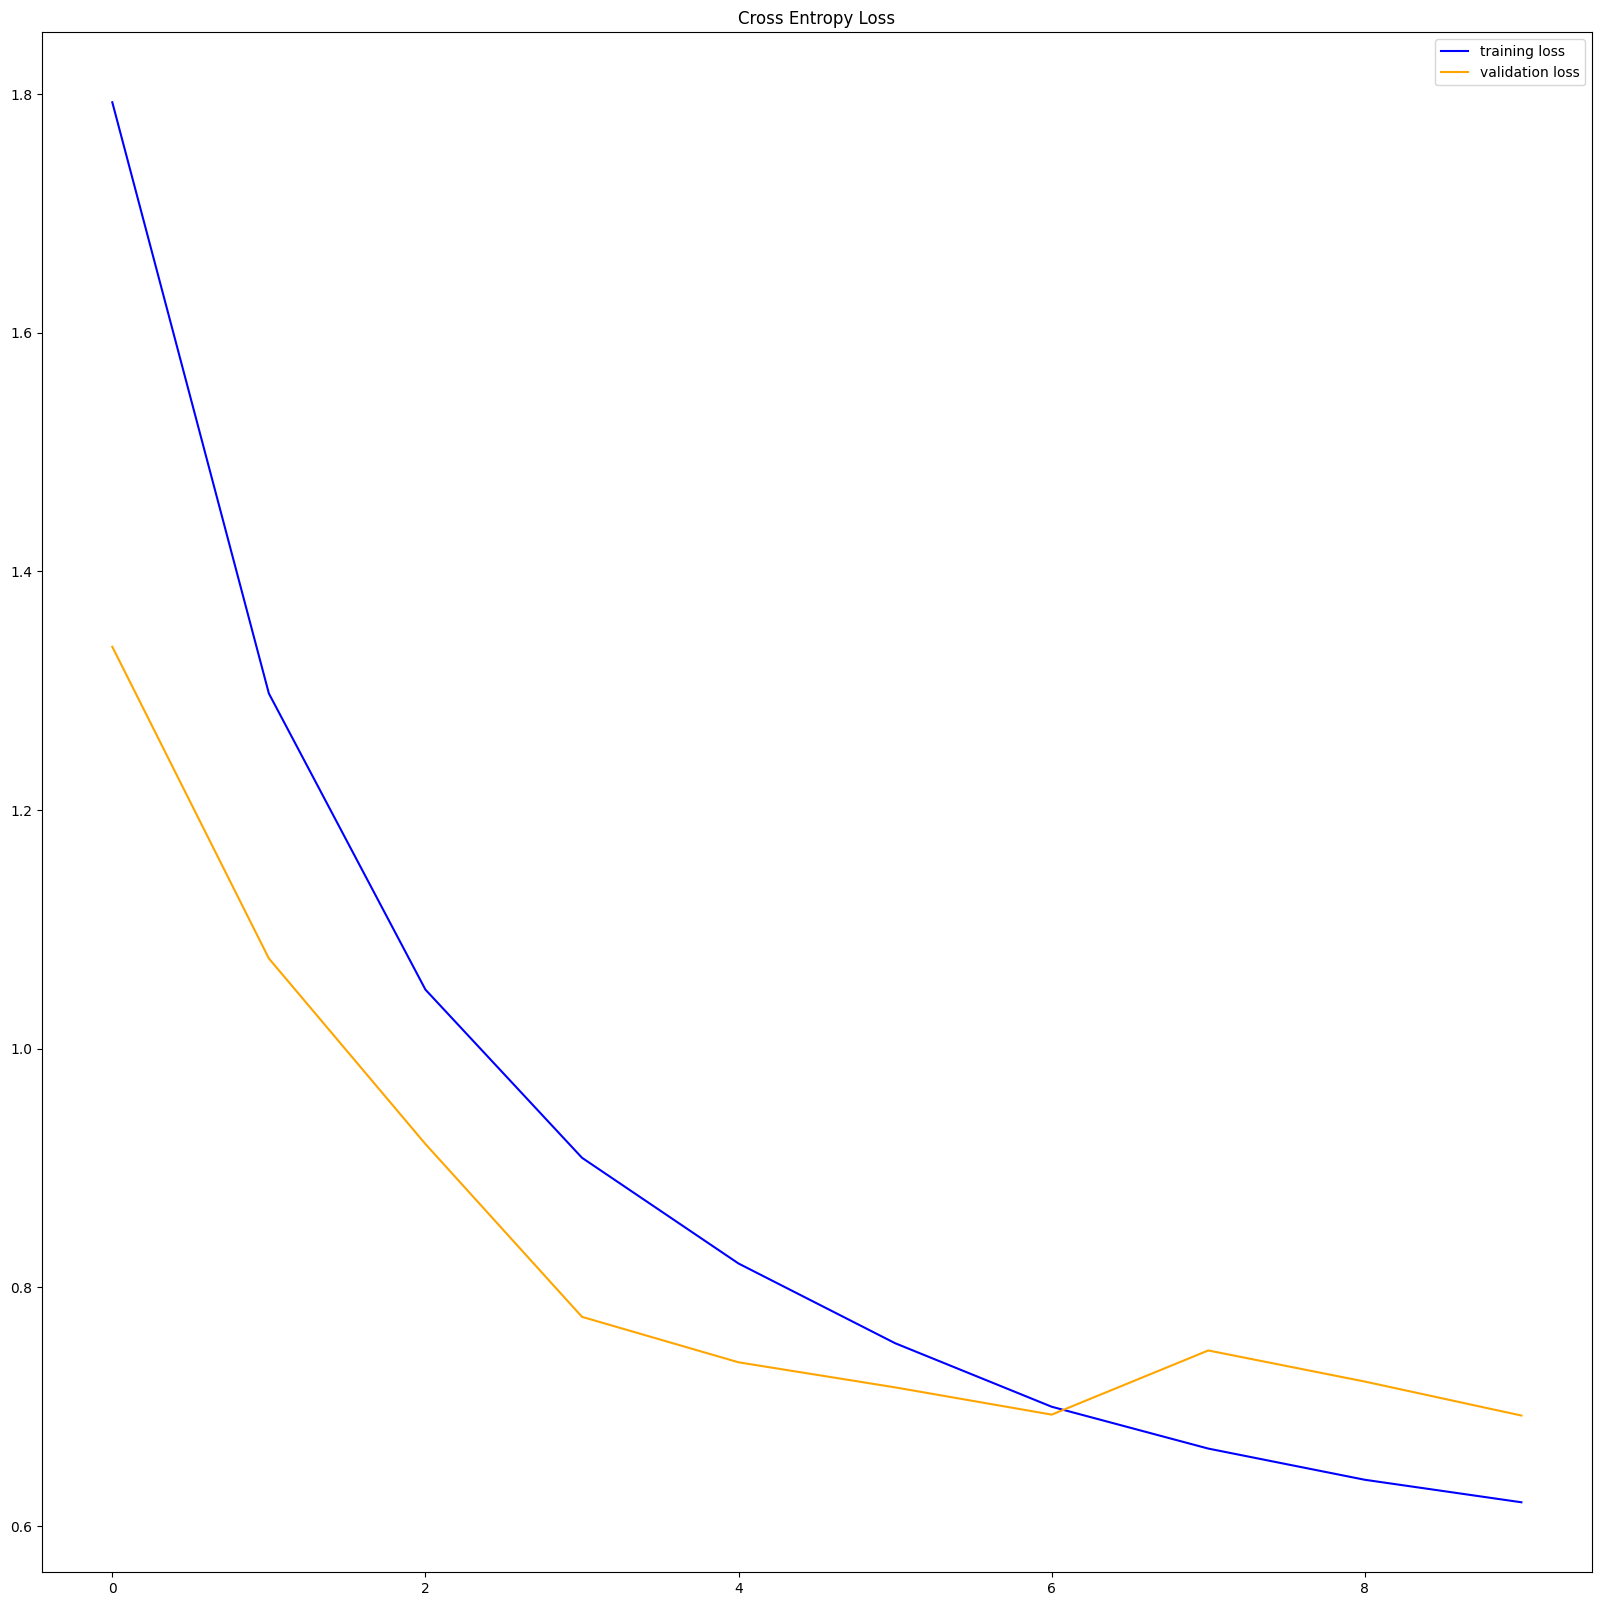

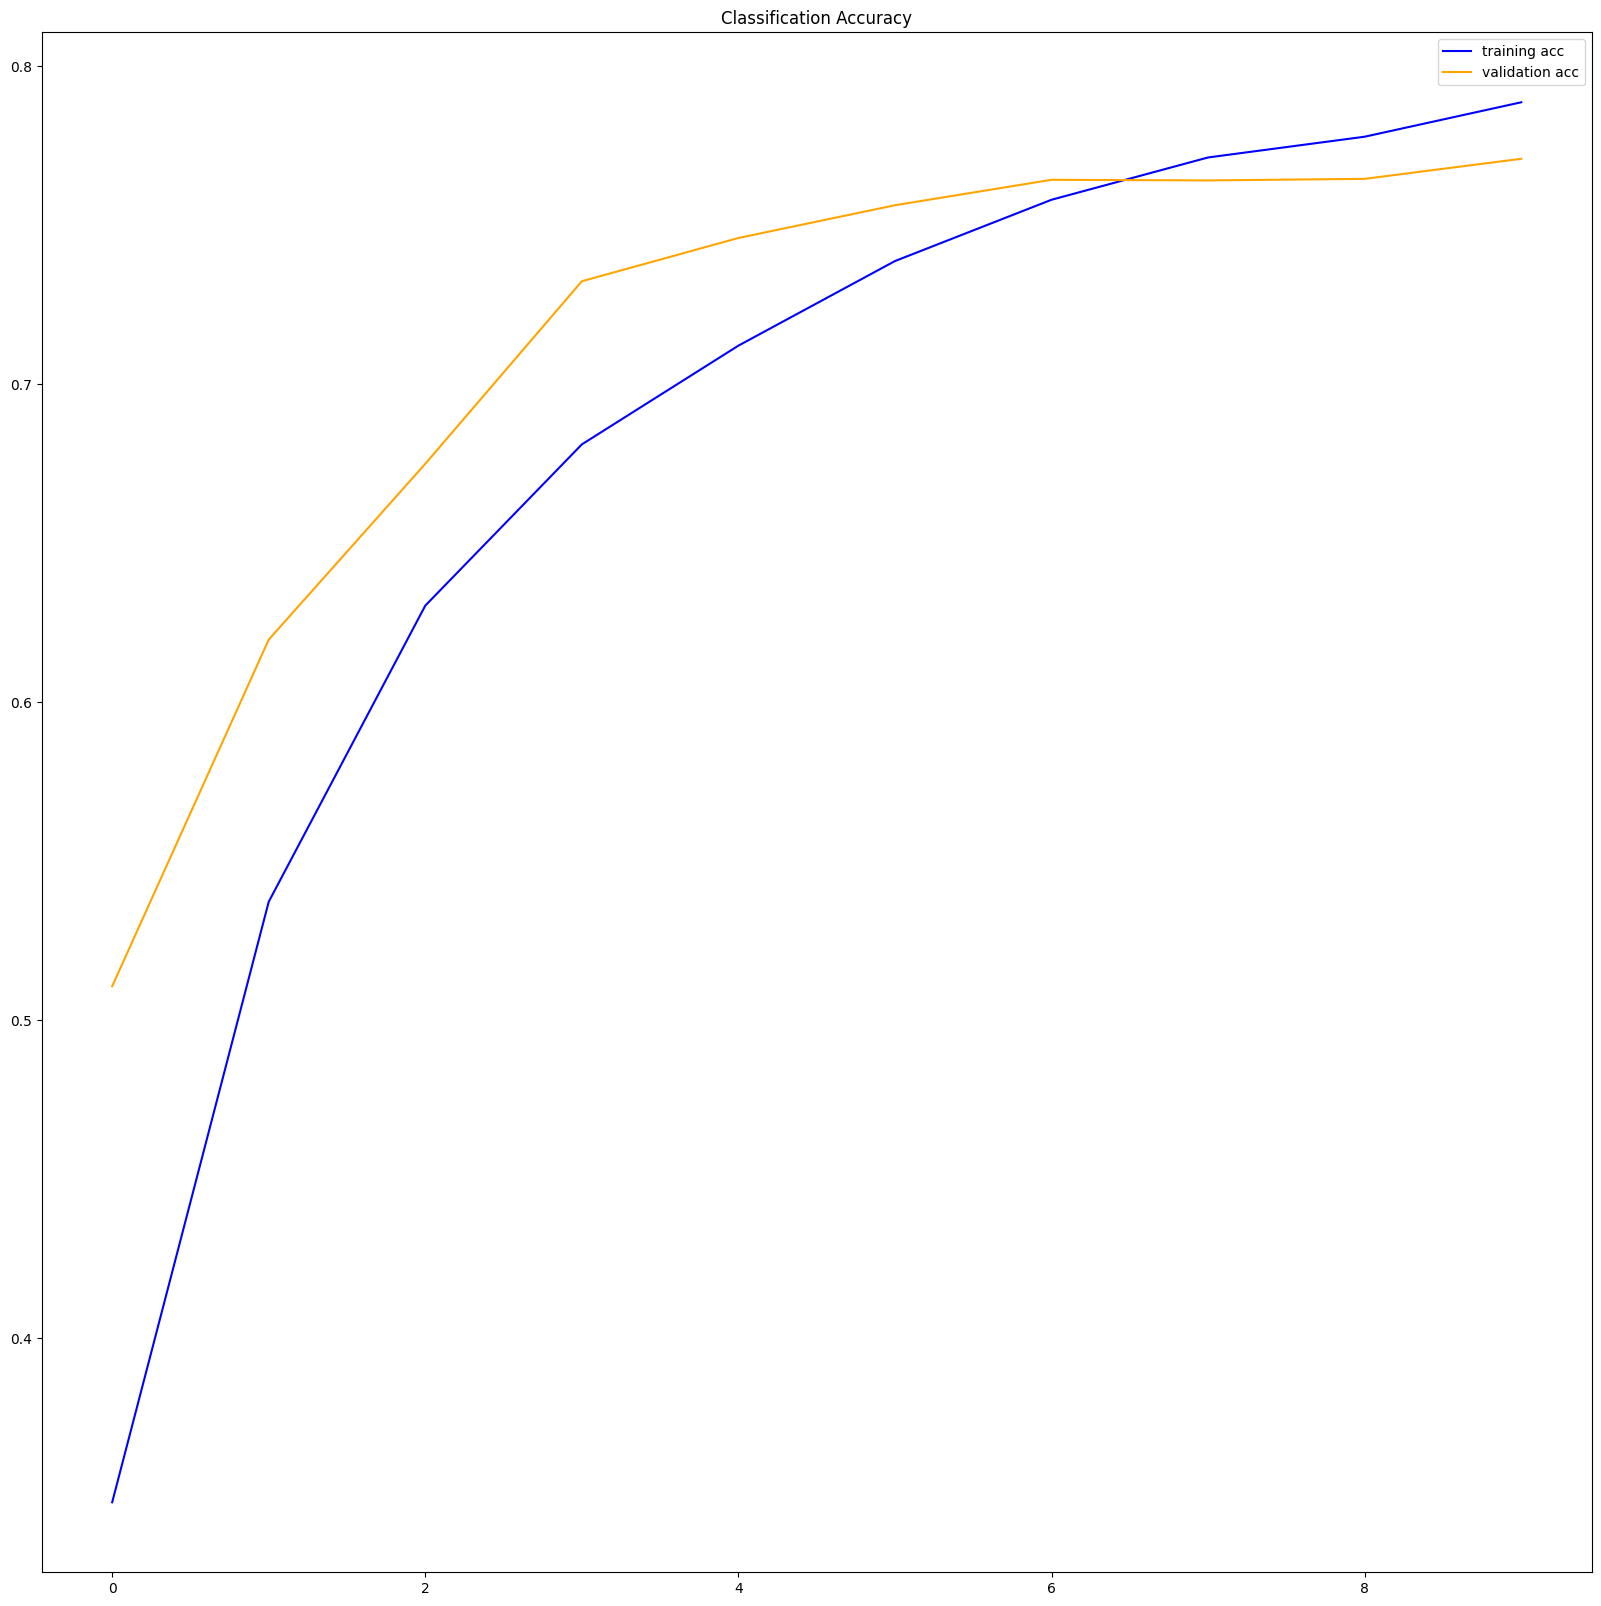

In [8]:
# We plot the learning curves (loss and accuracy)

# plot loss
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training loss')
plt.plot(history.history['val_loss'], color='orange', label='validation loss')
plt.legend()
plt.show()

# plot accuracy
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='training acc')
plt.plot(history.history['val_accuracy'], color='orange', label='validation acc')
plt.legend()
plt.show()


Now, we need to define a few plots ... just execute !

In [9]:
class_definition = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
                    4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship',
                    9: 'truck'}

from matplotlib.colors import to_hex

# definition of the scatterplot
def make_scatterplot(X, y, feature1=None, feature2=None,
                     class_indices=None, class_definition=None):
    if class_indices is None:
        class_indices = np.unique(y)
    if class_definition is None:
        class_definition = dict(zip(class_indices, [str(i) for i in class_indices]))
    if feature1 is None:
      feature1 = 'Component 1'
    if feature2 is None:
      feature2 = 'Component 2'

    # colors
    colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title('Scatter plot: %s vs. %s' % (feature2, feature1))

    comp1 = X[:,0]
    comp2 = X[:,1]
    for class_index in class_indices:
        class_label = class_definition[class_index]
        ax.scatter(comp1[y==class_index],
                   comp2[y==class_index],
                   c=to_hex(colors[class_index]),
                   label=class_label,
                   s=15)
    ax.legend()
    ax.grid()

Now, we will extract the features of a layer and visualize the distribution of the encodings with t-SNE.

First, we start with layer `flatten`. This is the last layer before the dense layers in the network.

In [10]:
from tensorflow.keras.models import Model

# we limit ourselves to 1000 training samples. t-SNE does not scale
# very well with the number of samples.
x = x_data[:1000]
y = y_data[:1000]

layer_name = 'flatten'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
features = intermediate_layer_model.predict(x)

print(features.shape)

32/32 [==============================] - 0s 10ms/step
(1000, 2048)


Finally, we perform t-SNE.

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


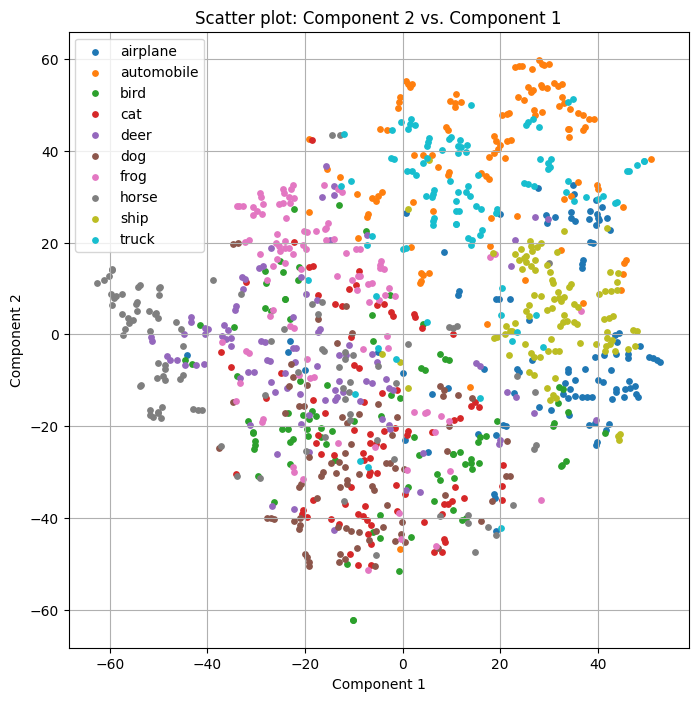

In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


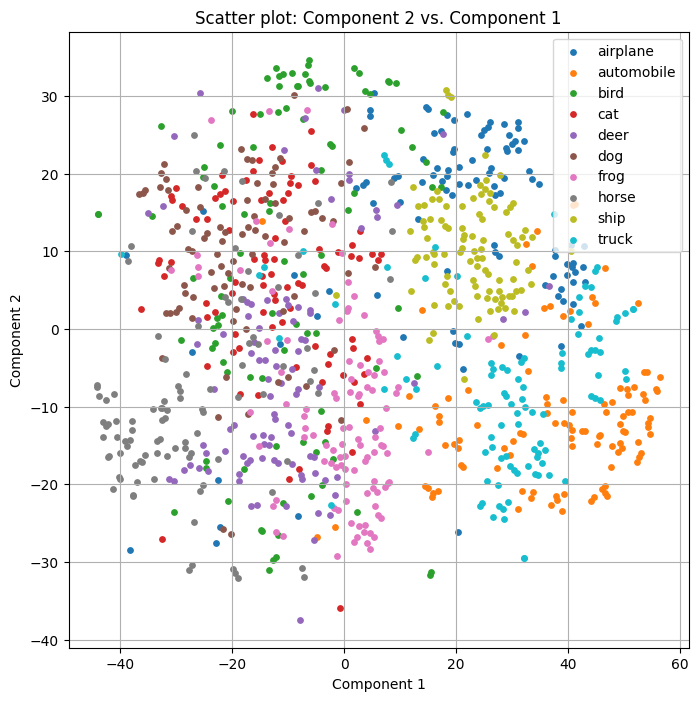

In [12]:
X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


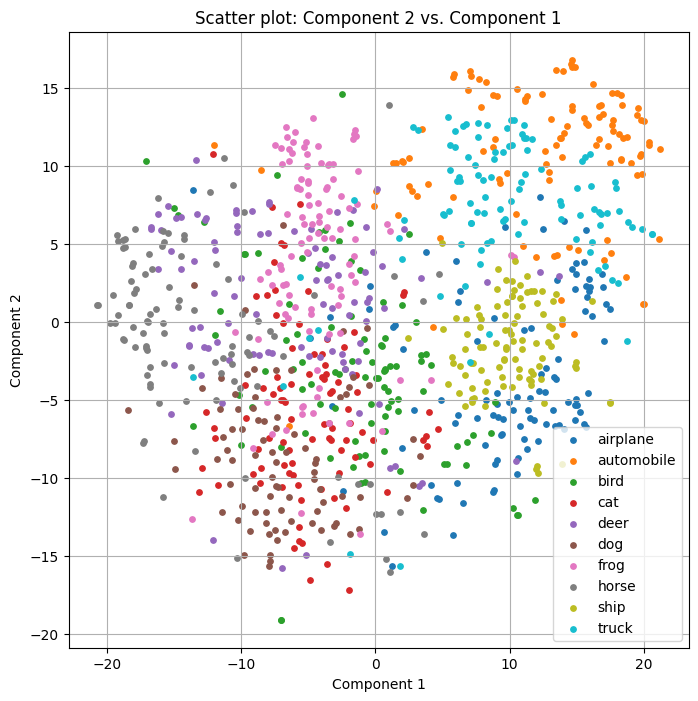

In [13]:
X_embedded = TSNE(n_components=2, perplexity=30).fit_transform(features)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

**Assignment**: Explain what is a feature vector (hint: other terms in the literature are "Encodings", "Embeddings")

**Answer**:  
A feature vector is a numerical representation of an image in a feature space. In other words, it's a compact and numerical representation of the essential features of the data instance that is suitable for analysis, comparison or future processing.

**Assignment**: Try out several perplexities: 5, 10, 30. What do you observe?

**Answer**: Perplexity parameter roughly controls the number of nearest neighbors used for visualization.

A higher perplexity(like 30) provides a more global view of the data, while a lower perplexity(like 5) focuses more on the local structure. A moderate perplexity(like 10) balances local and global aspects.

**Assignment**: Visualize now the scores at the two fully connected layers. Why are the representations so strikingly different? Imagine you would like to use the same representations in another project (same image size, but other classes). Which of the representations seems less useful? Why?

32/32 [==============================] - 0s 3ms/step
(1000, 128)


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


32/32 [==============================] - 0s 3ms/step
(1000, 10)


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


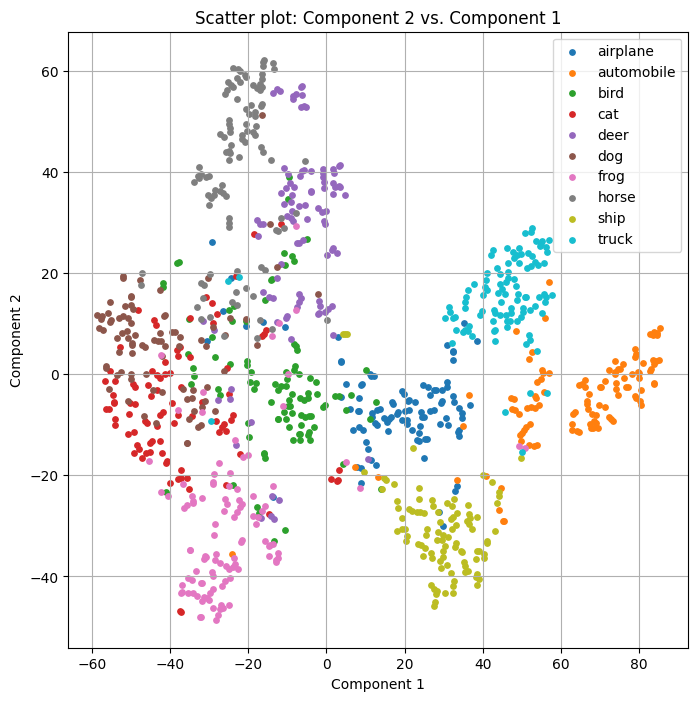

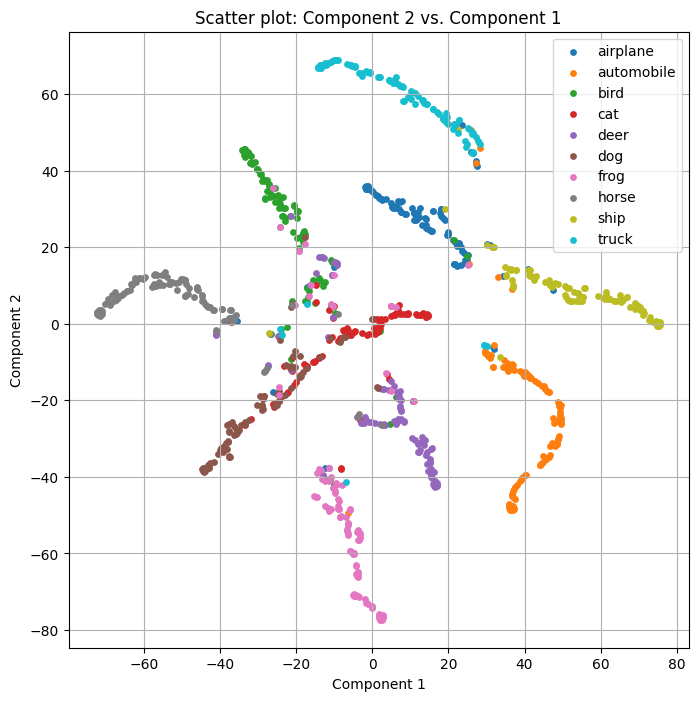

In [14]:
# the first fully connected layer
layer_name = 'dense'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
scores = intermediate_layer_model.predict(x)

print(scores.shape)

X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(scores)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

# the second fully connected layer
layer_name = 'dense_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
scores = intermediate_layer_model.predict(x)

print(scores.shape)

X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(scores)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

**Answer**: The representations at the two fully connected layers are strikingly different because:

Depth and Abstraction: The second fully connected layer is deeper in the network and captures more abstract and high-level features compared to the first fully connected layer. As we move deeper into the network, features become increasingly abstract and specialized.  

Non-Linear Transformations: Each layer applies non-linear transformations to the input, making the representations highly non-linear. These non-linear transformations lead to distinct and complex features in each layer.

**Answer**: The second fully connected layer is likely less useful for a different project with the same image size but different classes.  

This is because it captures highly specialized and task-specific features related to the original classification task, which may not be relevant or transferable to the new set of classes. On the other hand, the first fully connected layer captures more general features that might have broader applicability and can serve as a better starting point for transfer learning to a different task.

**Assignment**: Visualize the tSNE plot of the model before training, what do you observe? (flatten layer and last fully_connected layer)

In [15]:
# a new same model before training
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

32/32 [==============================] - 0s 3ms/step
(1000, 2048)
 1/32 [..............................] - ETA: 2s

<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


32/32 [==============================] - 0s 2ms/step
(1000, 10)


<ipython-input-9-5a944b56079f>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10).colors[:,:3]


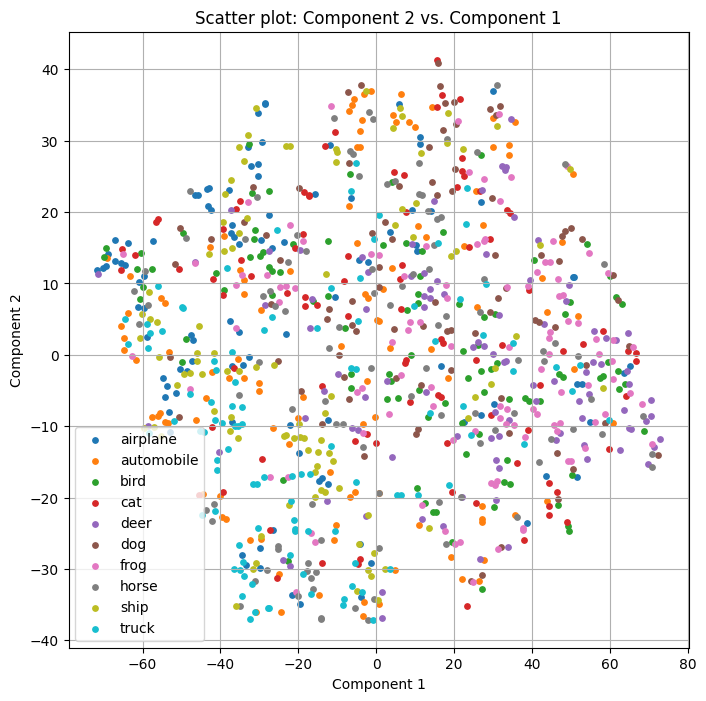

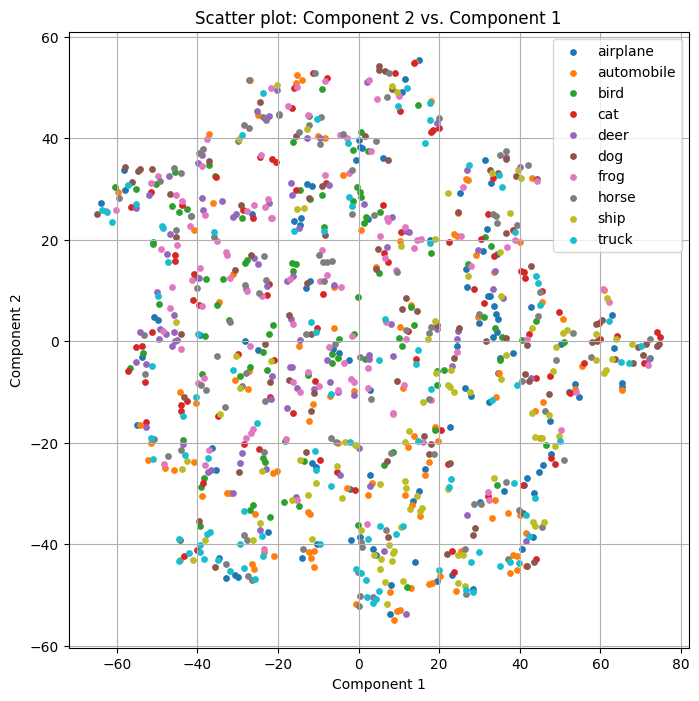

In [16]:
# flatten layer
layer_name = 'flatten_1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
scores = intermediate_layer_model.predict(x)

print(scores.shape)

X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(scores)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

# last fully connected layer
layer_name = 'dense_3'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
scores = intermediate_layer_model.predict(x)

print(scores.shape)

X_embedded = TSNE(n_components=2, perplexity=10).fit_transform(scores)
make_scatterplot(X_embedded, y.flatten(), class_definition=class_definition)

**Answer**: Both t-SNE plots for the Flatten Layer and the last Fully Connected Layer appear similar before training.   
This similarity suggests that the initial feature representations at both layers are relatively generic and not yet specialized for the specific classification task.

# Classification activation maps (grad-CAM)

Classification activation maps provide certainly the most popular visualization methods for network inspection.

In [17]:
!pip install --upgrade tf-keras-vis

In [18]:
from tf_keras_vis.gradcam import Gradcam

Next, we will load VGG16, pretrained on `ImageNet`. This is the network we are going to investigate.

In [19]:
# Pretrained network: VGG16
from tensorflow.keras.applications import VGG16

# We want to extract the entire network, including the finaly layer.
model = VGG16(weights='imagenet',include_top=True)

# We show the summary of model (to recall the dimensions)
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now, we load an image from the `ImageNet` data base. We have downloaded these images: they are in the folder `imagenet`.

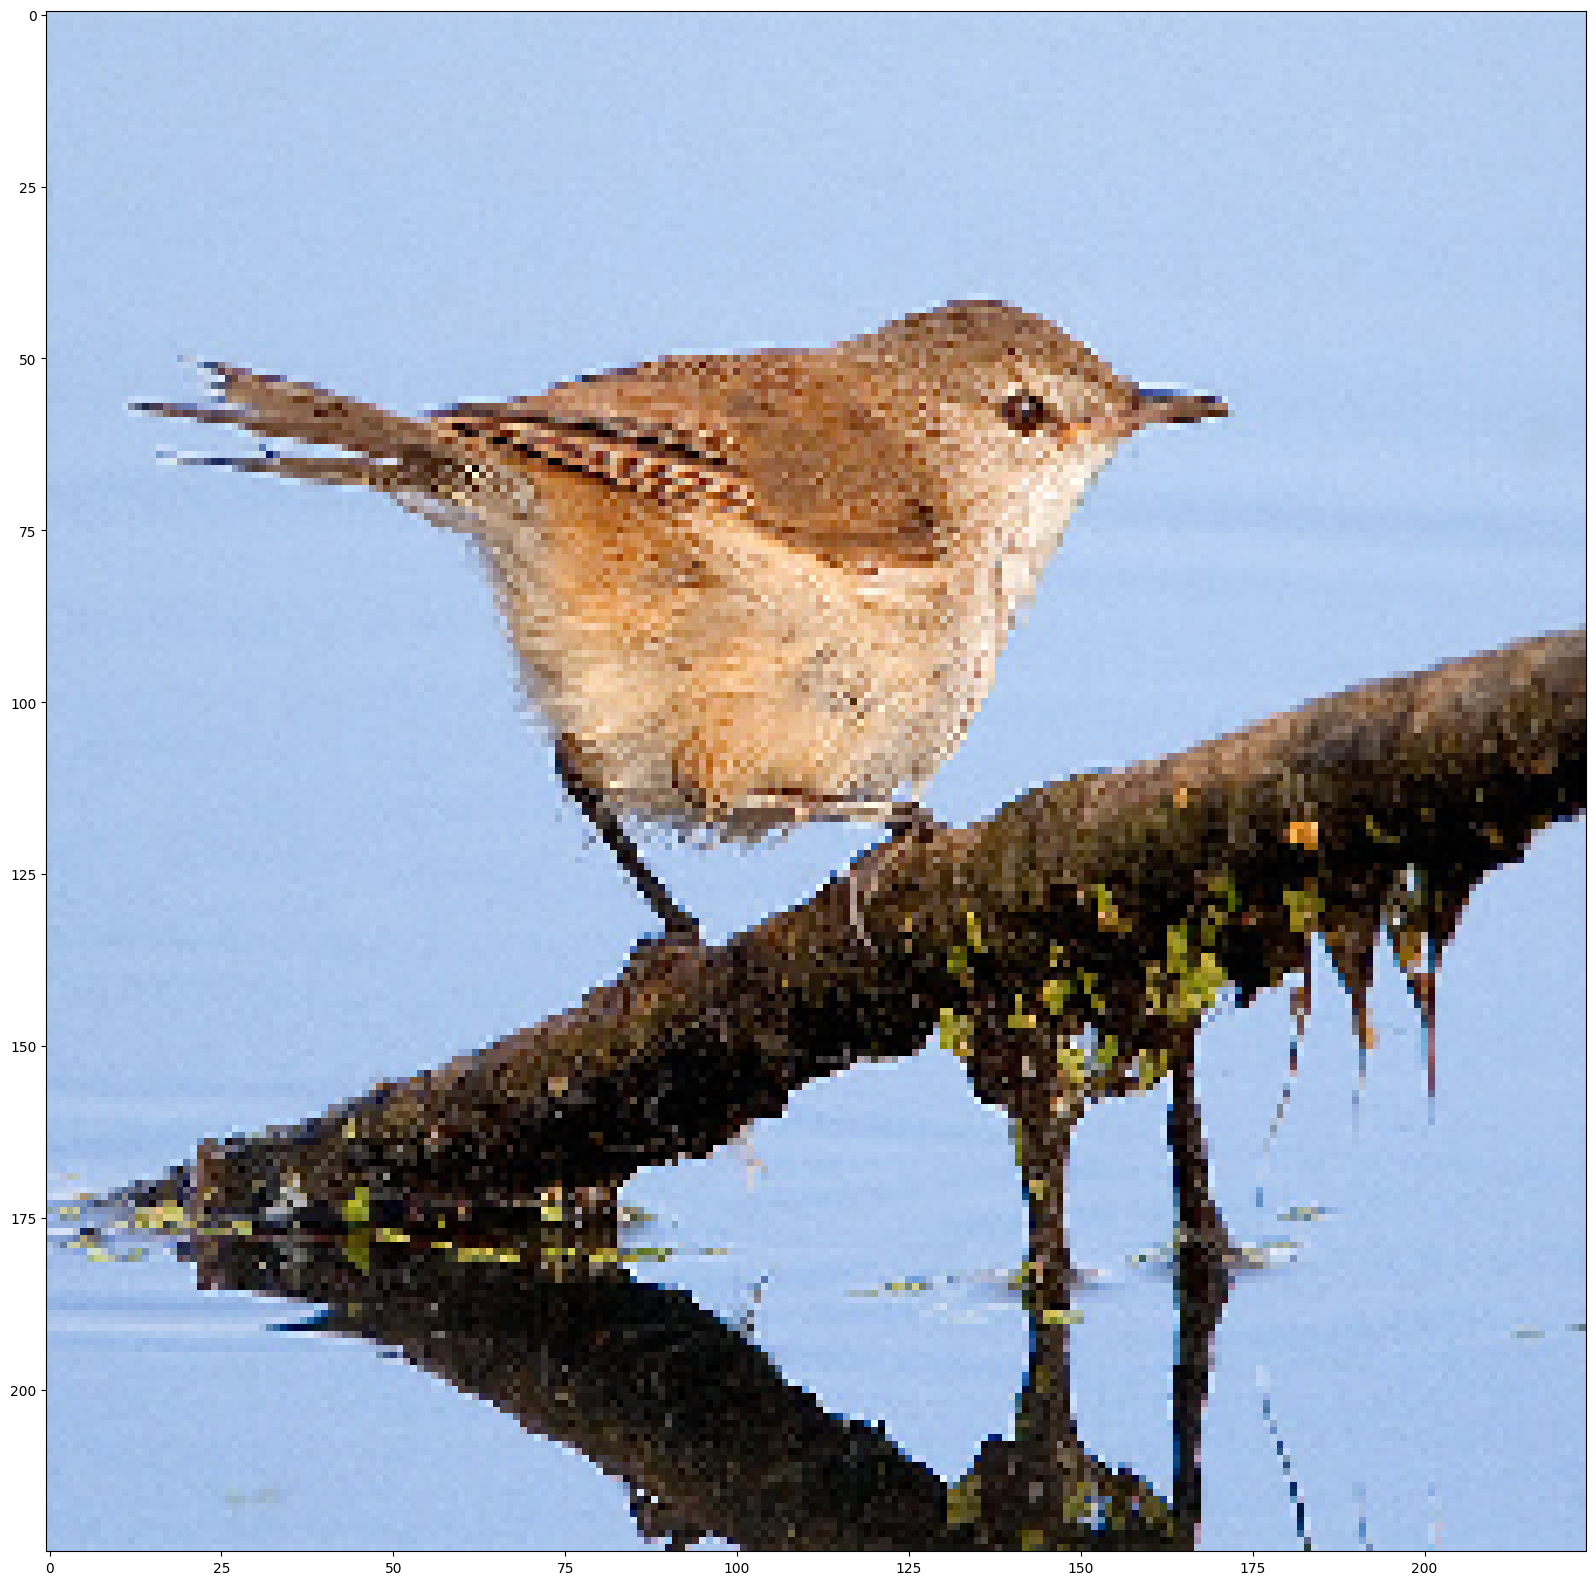

In [20]:
import os
filename = '418657219_3567961db1.jpg'

folder_name = '/content/gdrive/My Drive/Colab Notebooks/M2-IASD/DL for image analysis/TP2-Visualization/imagenet'
from tensorflow.keras.preprocessing.image import load_img
image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))
plt.imshow(image)


Now, we will predict the label of the image.

In [21]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

# convert the image pixels to a numpy array
img_prep = img_to_array(image)

# reshape data (the model expects a batch of images.)
img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))

# prepare the image for the VGG model
img_prep = preprocess_input(img_prep)

# predict the probability across all output classes
img_prediction = model.predict(img_prep)

# the output is a 1000-dimensional vector of posterior probabilities.
print('Shape of the output vector:', img_prediction.shape)

# result
print('Prediction result:', decode_predictions(img_prediction, top=3))
max_index = np.argmax(img_prediction)
print('Solution Index: ', max_index)

1/1 [==============================] - 1s 853ms/step
Shape of the output vector: (1, 1000)
Prediction result: [[('n01601694', 'water_ouzel', 0.99239105), ('n02027492', 'red-backed_sandpiper', 0.0048558787), ('n02028035', 'redshank', 0.0018742515)]]
Solution Index:  20


We need to define a few helper functions. First the `model_modifier` that replaces the `softmax` by a linear layer. The reason is that we cannot study the influence of neurons on the output $y_k$, if the output depends on all classes (which is the case when we use `softmax`).

In [22]:
# model modifier
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

def loss(img_prediction):
    # the loss gives the score of the image for the correct class.
    # if you want to test the importance for the prediction of another class
    # you have to adapt the index accordingly.
    correct_class_index = np.argmax(img_prediction)
    return img_prediction[0][correct_class_index]

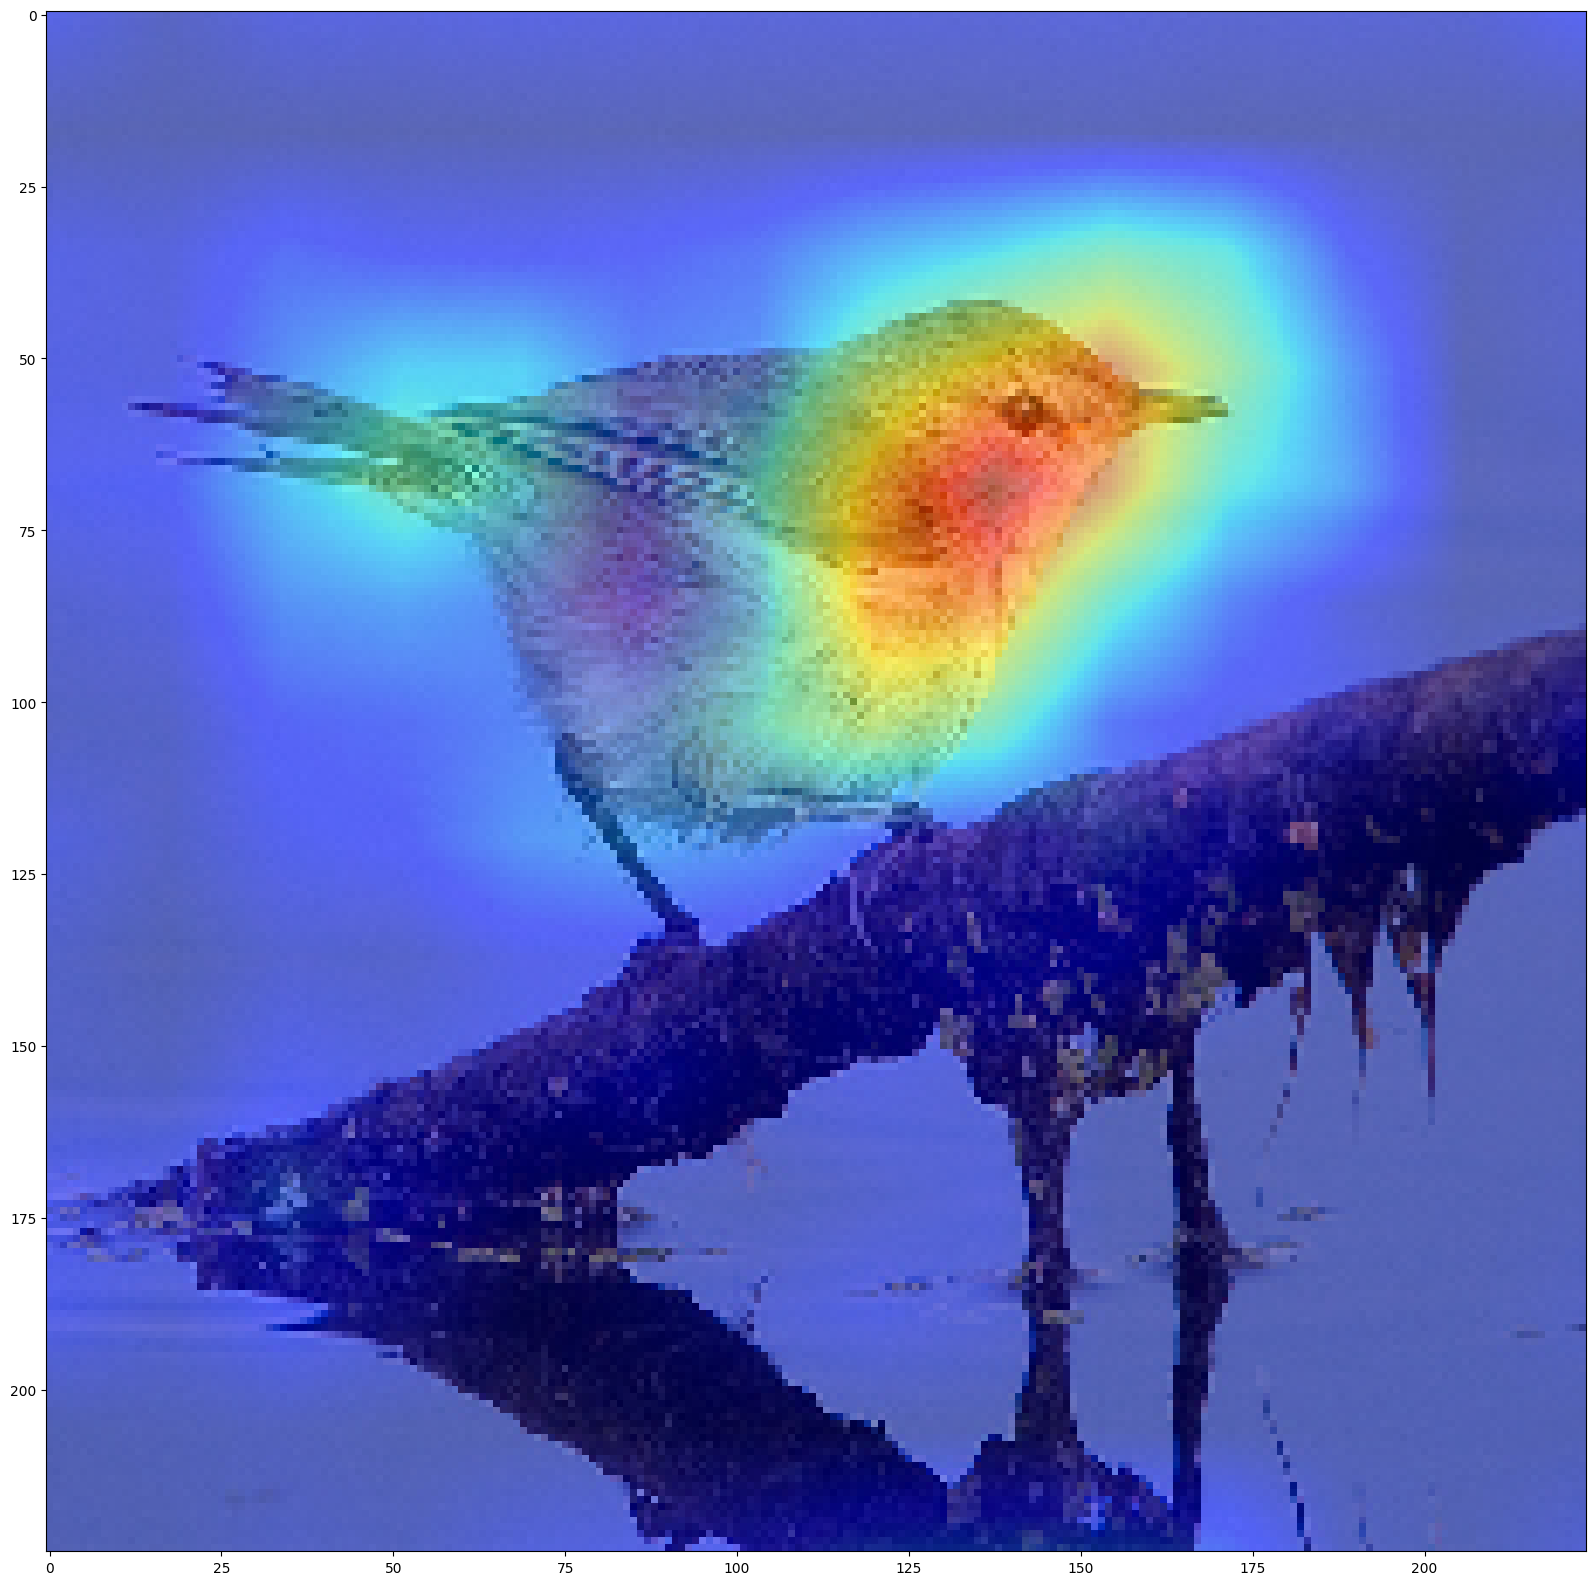

In [23]:
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=model_modifier,
                  clone=False)

# Generate heatmap with GradCAM
cam = gradcam(loss,
              img_prep,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

plt.imshow(image)
heatmap = np.uint8(cm.jet(cam[0]) * 255)
plt.imshow(heatmap, cmap='jet', alpha=0.5)


**Assignment:** Test the grad-CAM first on the three animal images, and verify that you obtain a reasonable result. Then test the algorithm on the three bridge images. Visualize the top-3 predictions.(Make a nice plot with the results)

*   For `Bridge1.jpg` you obtain a wrong classification, but what can be said about the learned network in view of the visualization of the top-3 predictions?
*   For `Bridge3.jpg` you get the right result, but what can you say about the "understanding" of the image in view of your visualization result?

Note that the correspondence of class names and indices can be found at:
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)


1/1 [==============================] - 0s 70ms/step


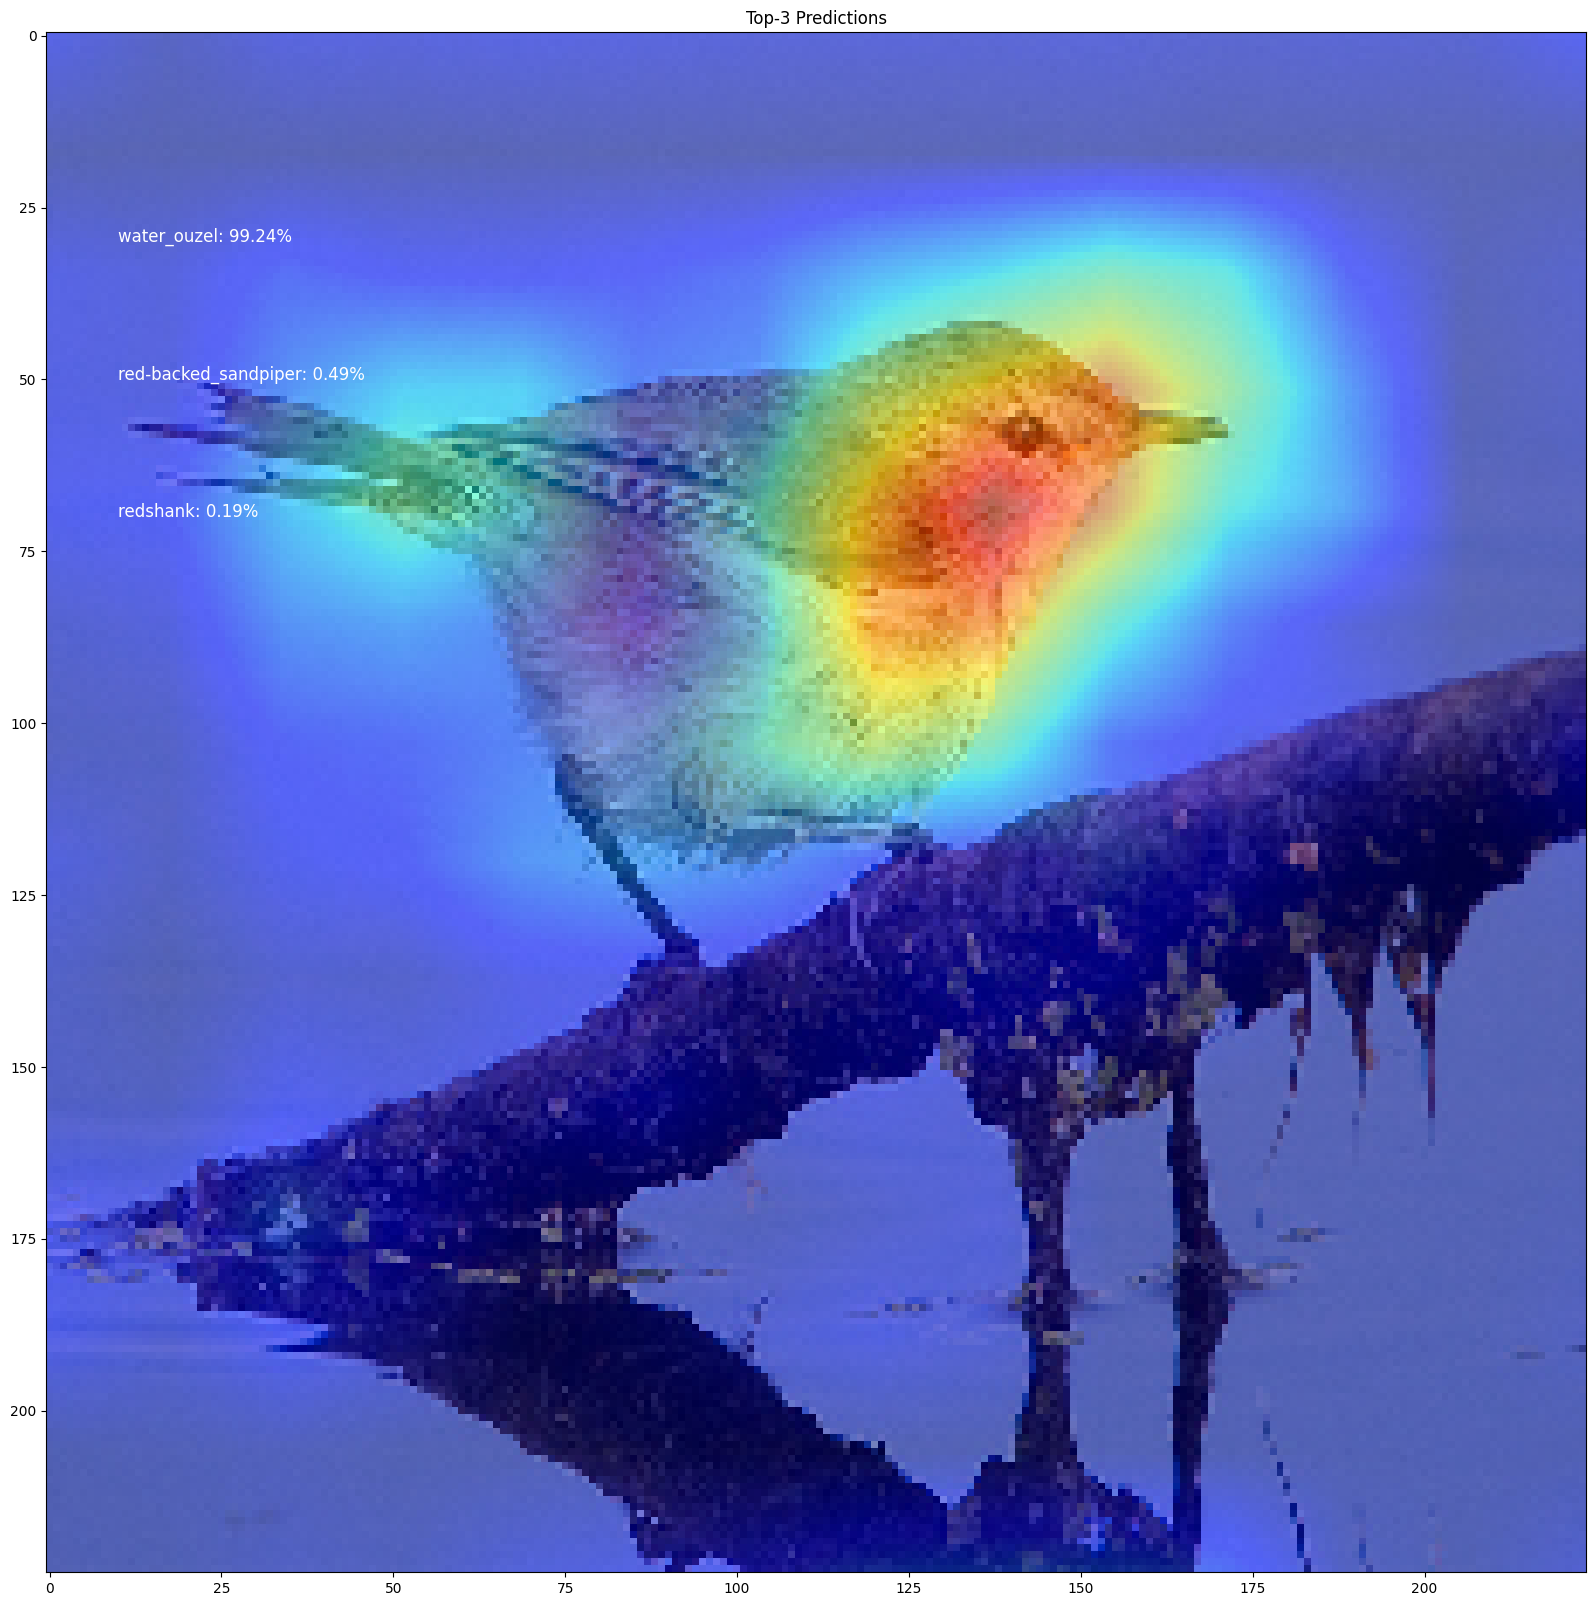

1/1 [==============================] - 0s 90ms/step


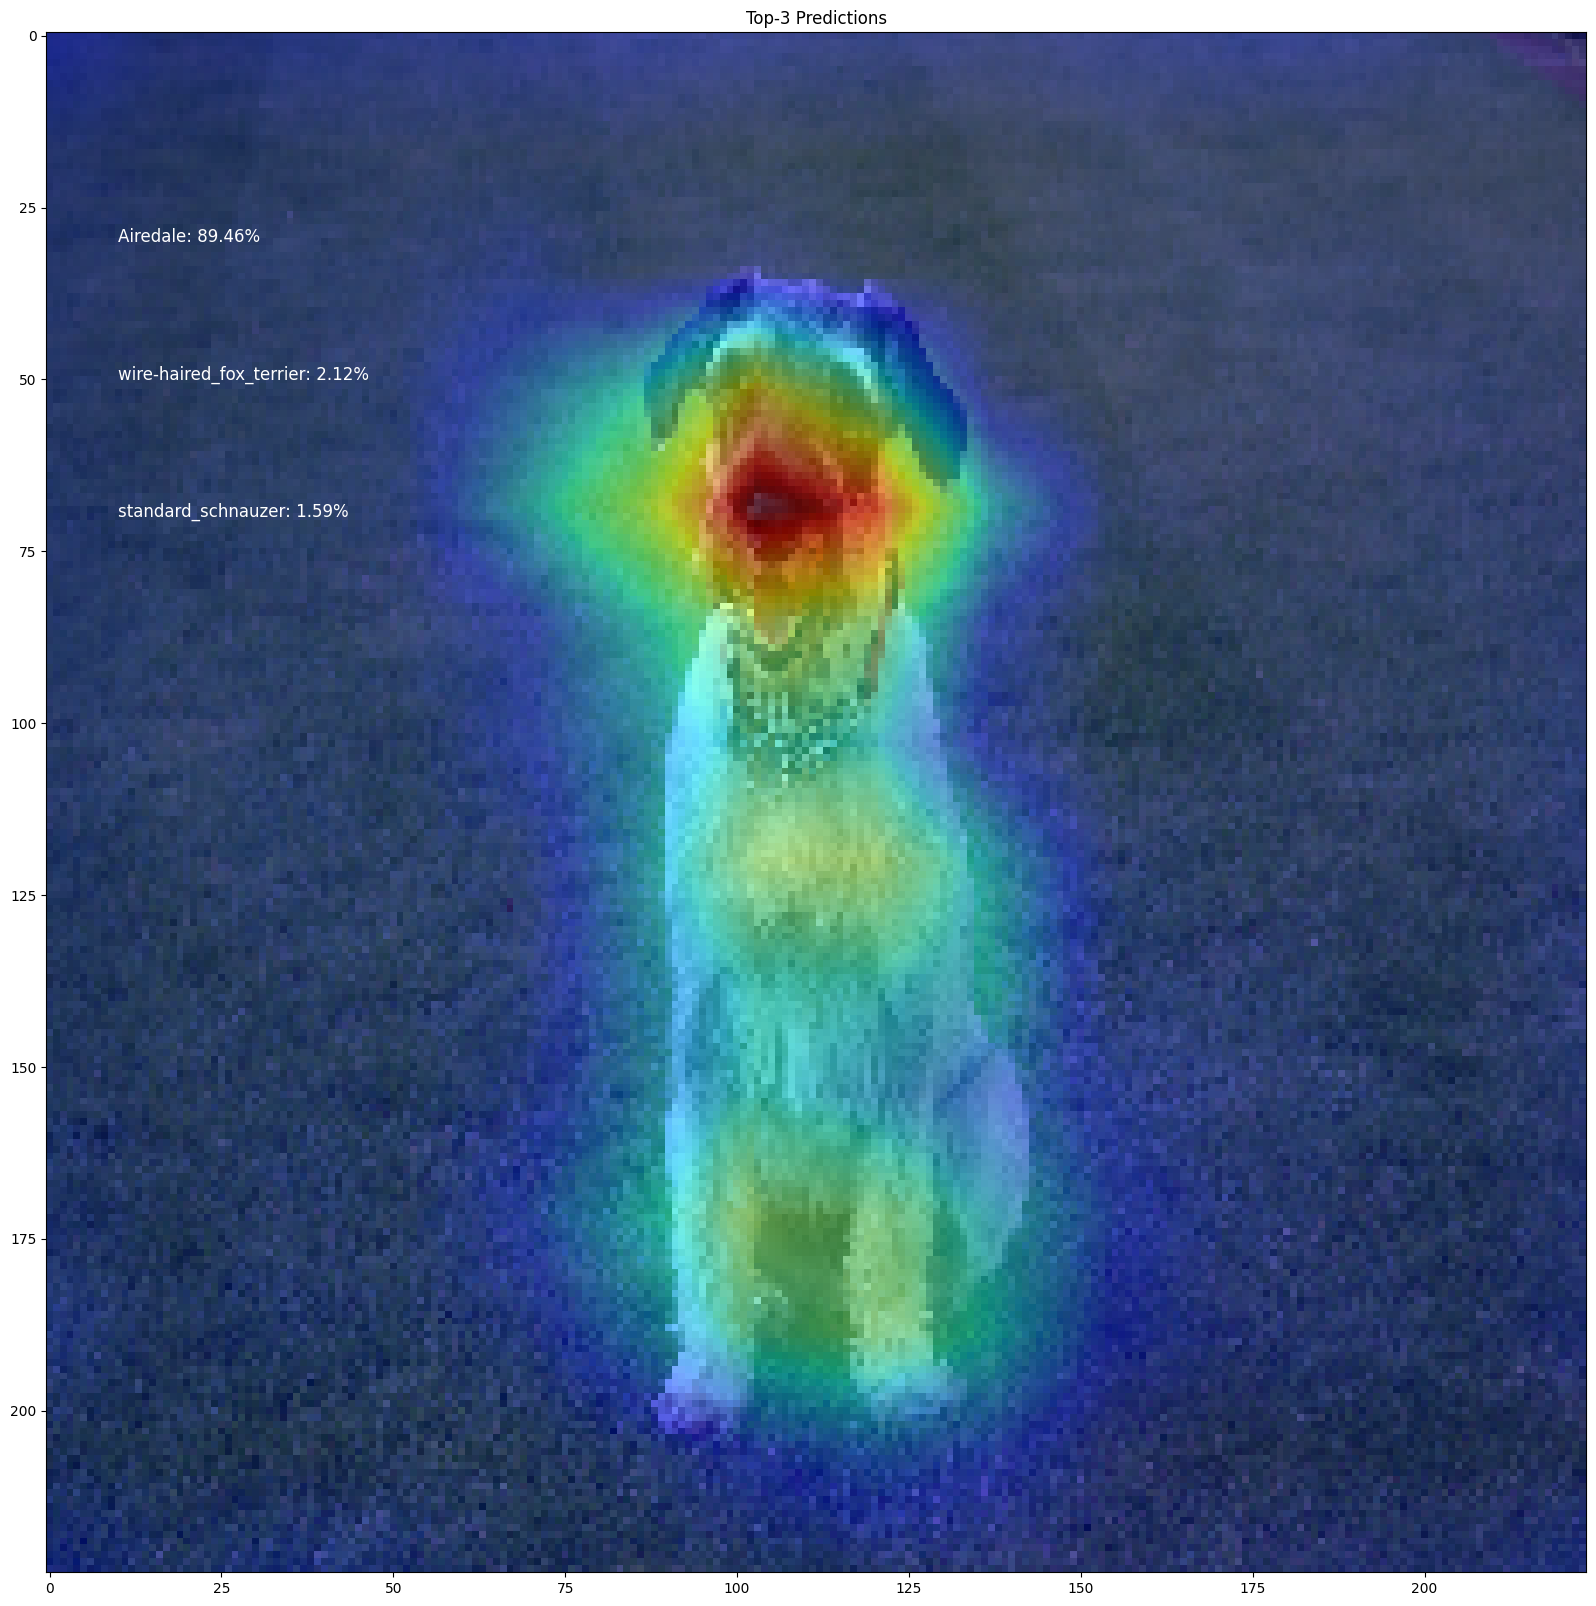

1/1 [==============================] - 0s 35ms/step


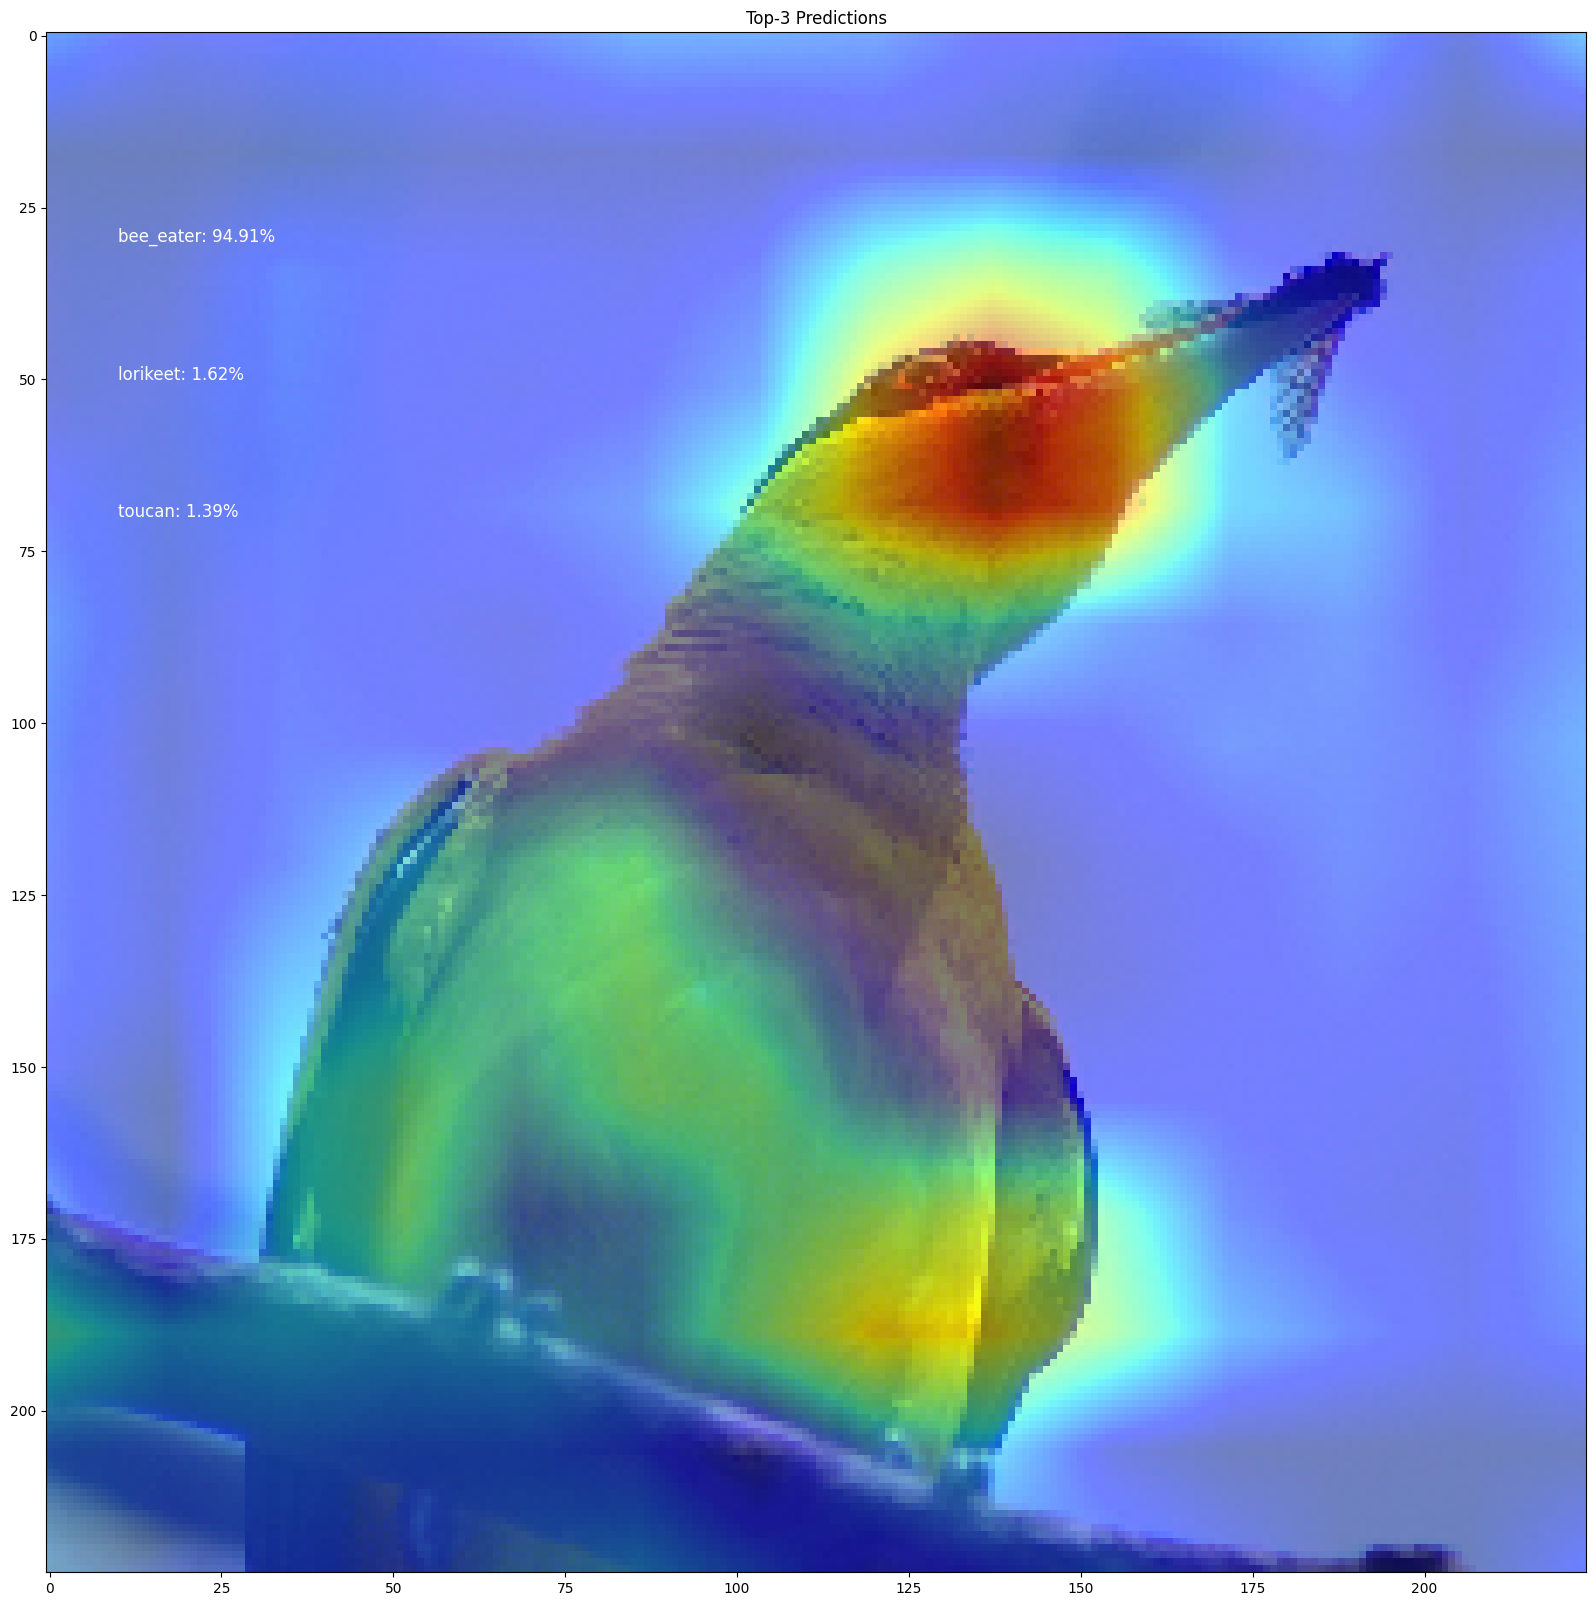

In [24]:
############### Test the grad-CAM on the three animal images and verify that we obtain a reasonable result ###############
############### Visualize the top-3 predictions.(Make a nice plot with the results) ###############

# animals:
# bird : filename = '418657219_3567961db1.jpg'
# dog : filename = '425248370_b15374000e.jpg'
# bird : filename = '485627874_8f4144223a.jpg'
animals = ['418657219_3567961db1.jpg', '425248370_b15374000e.jpg', '485627874_8f4144223a.jpg']
folder_name = '/content/gdrive/My Drive/Colab Notebooks/M2-IASD/DL for image analysis/TP2-Visualization/imagenet'

for filename in animals:
  # load image
  image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))

  # convert the image pixels to a numpy array
  img_prep = img_to_array(image)
  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))
  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)
  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)

  # Get top-3 predictions
  top3_predictions = decode_predictions(img_prediction, top=3)[0]

  # Create Gradcam object
  gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)
  # Generate heatmap with GradCAM
  cam = gradcam(loss,
                img_prep,
                penultimate_layer=-1, # model.layers number
                )
  cam = normalize(cam)

  # Visualize image and heatmap
  plt.imshow(image)
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  plt.imshow(heatmap, cmap='jet', alpha=0.5)

  # Display top-3 predictions
  plt.title("Top-3 Predictions")
  for i, (_, class_name, prob) in enumerate(top3_predictions):
      plt.text(10, 30 + i * 20, f"{class_name}: {prob * 100:.2f}%", color='white', fontsize=12)
  plt.show()


1/1 [==============================] - 0s 29ms/step


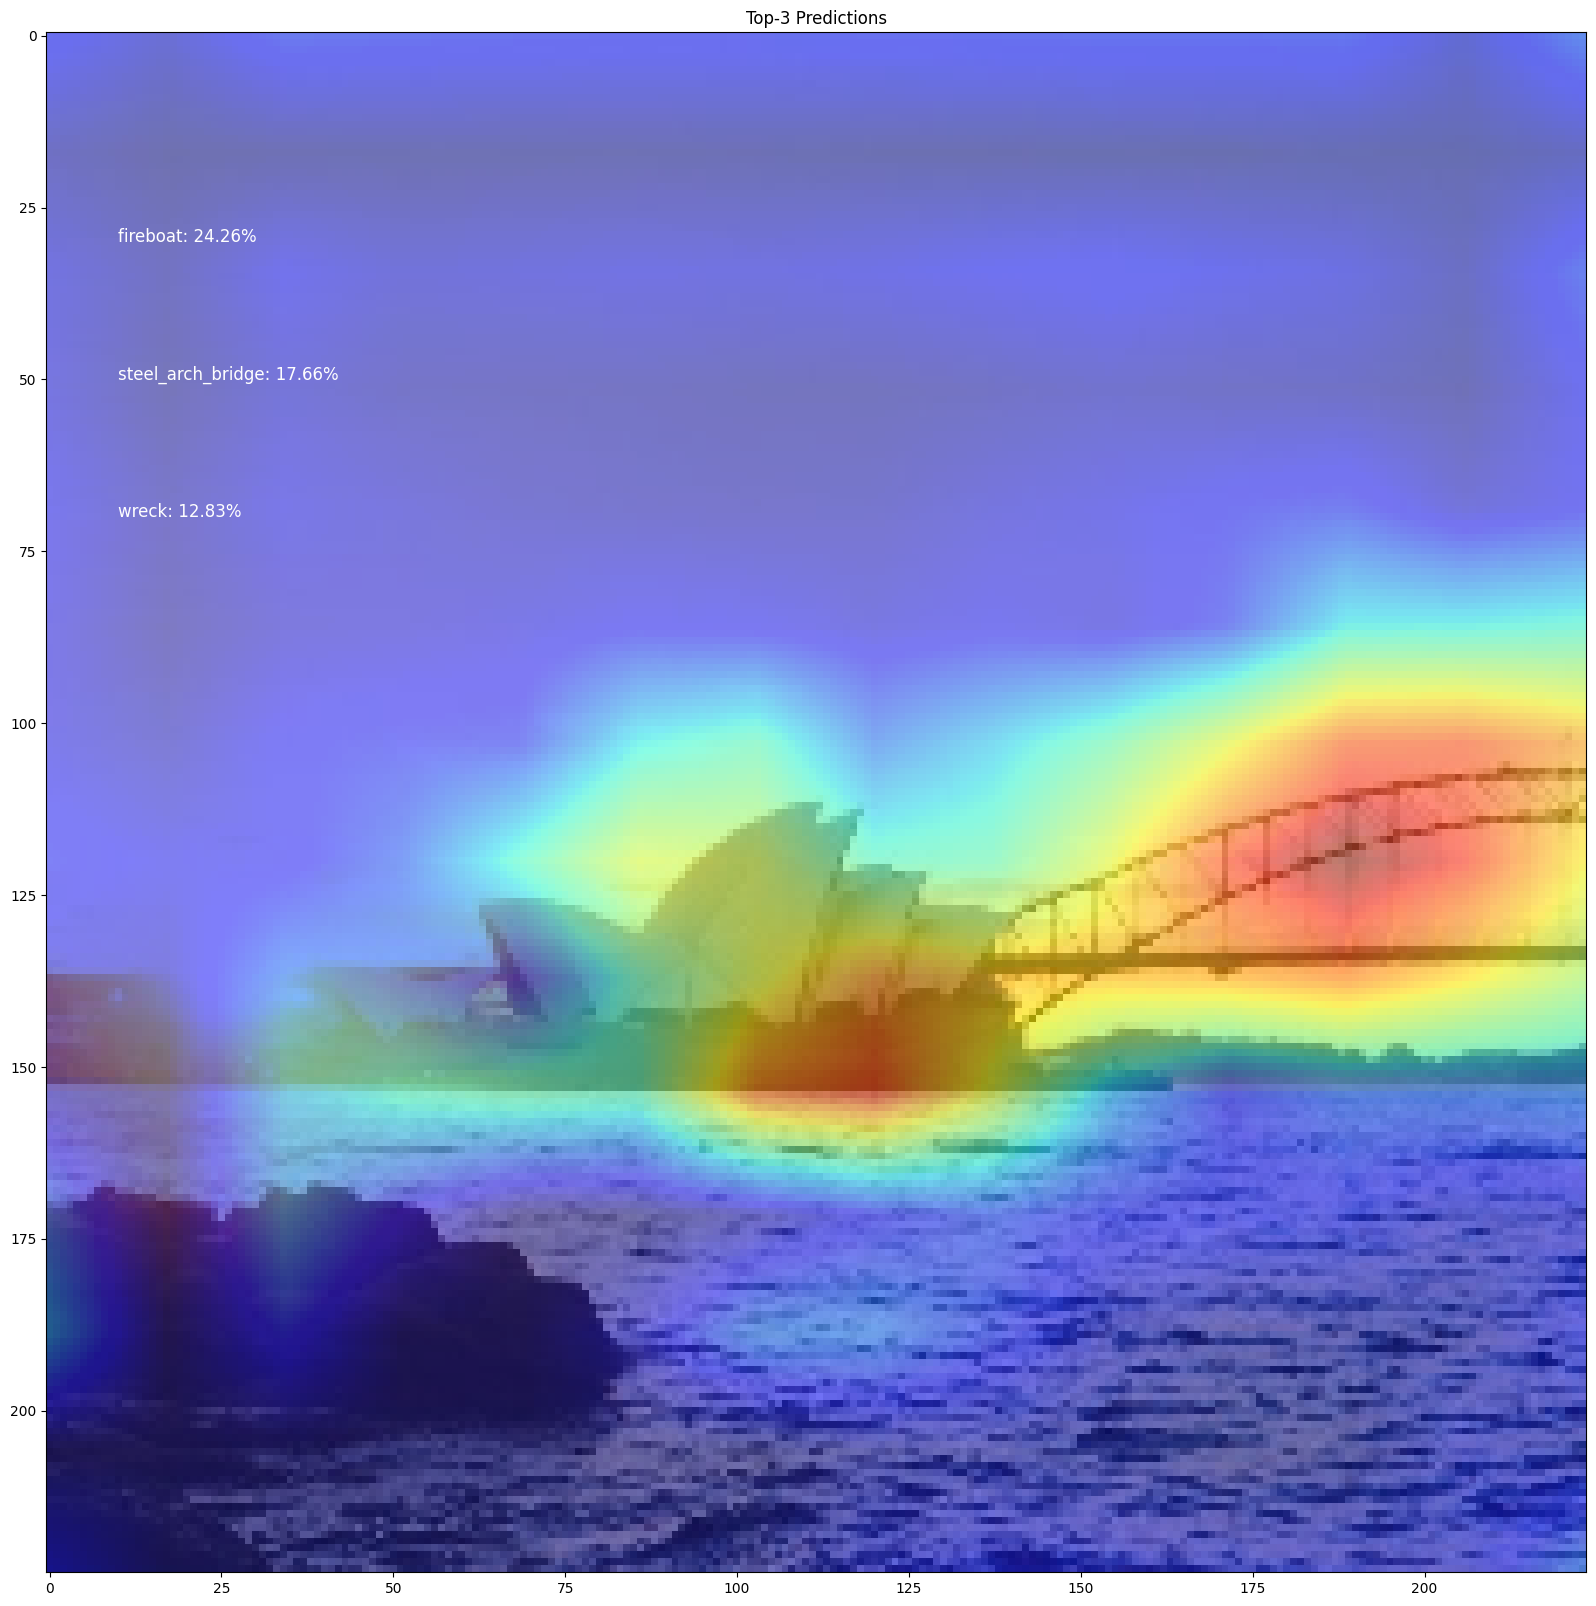

1/1 [==============================] - 0s 37ms/step


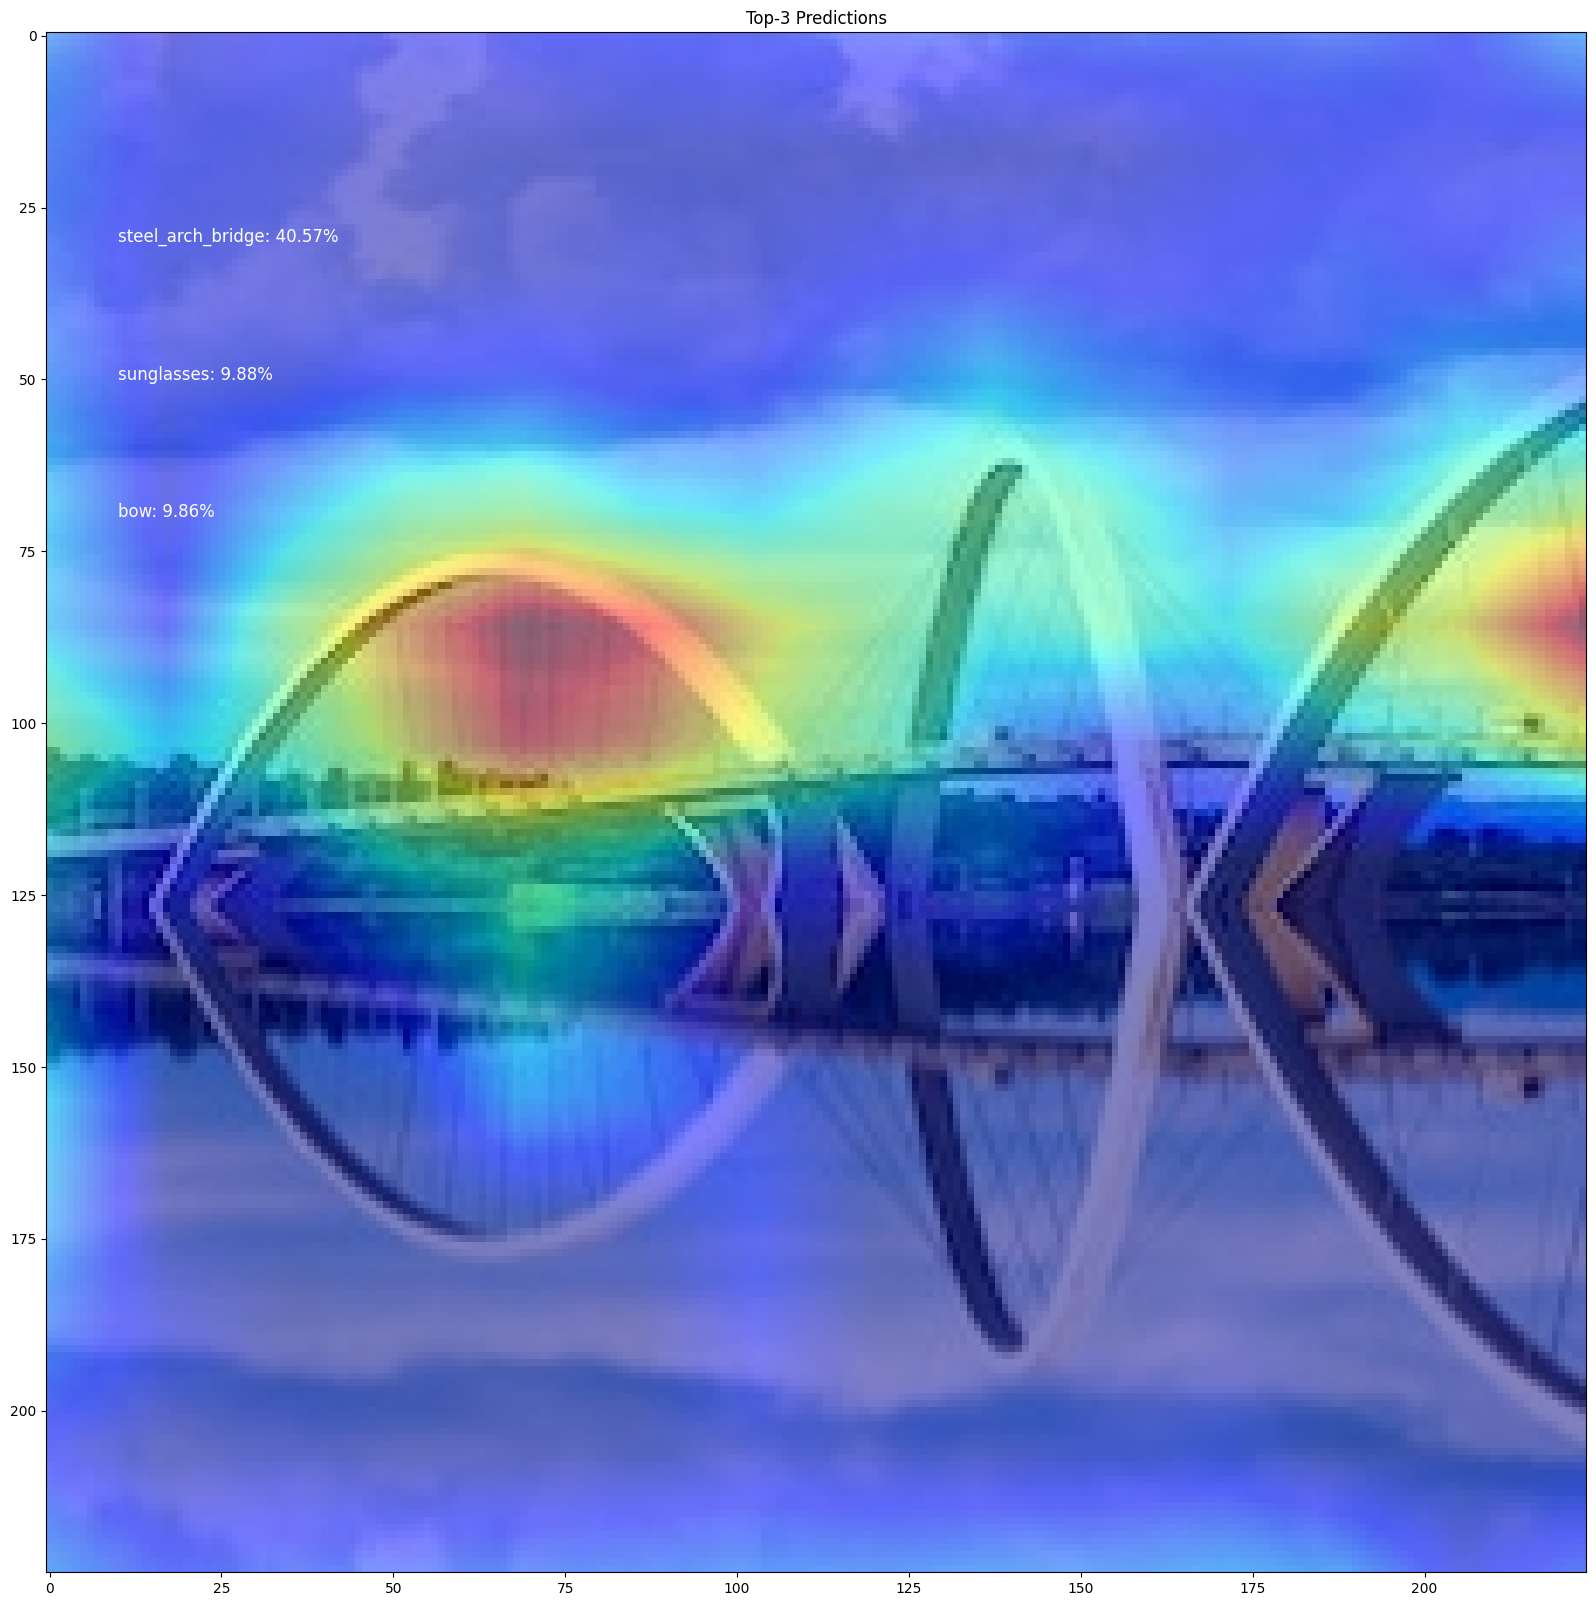

1/1 [==============================] - 0s 42ms/step


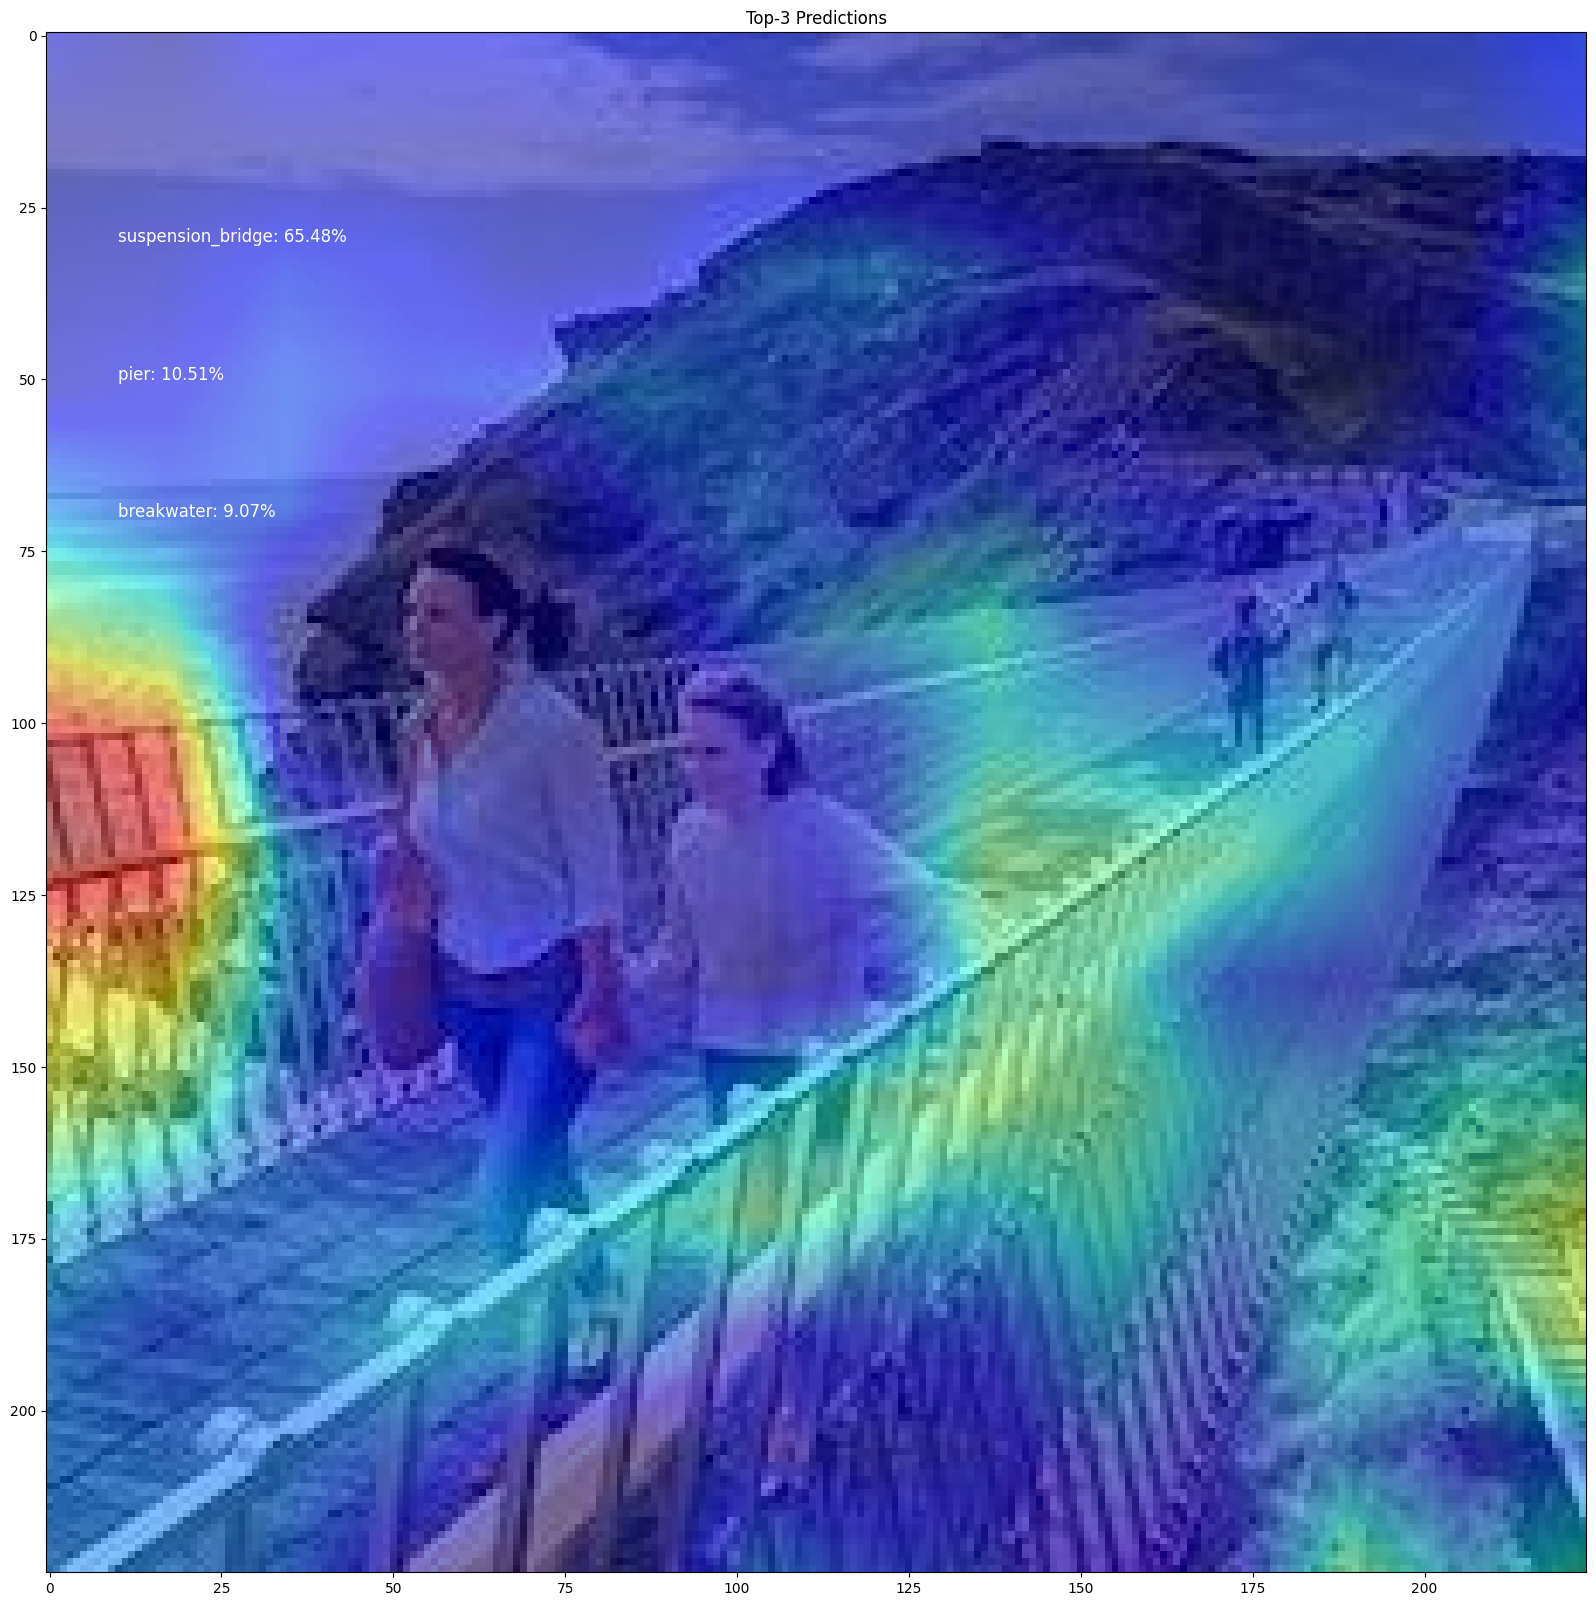

In [25]:
############### Test the grad-CAM on the three bridges images and verify that we obtain a reasonable result ###############
############### Visualize the top-3 predictions.(Make a nice plot with the results) ###############

# bridges:
# filename = 'bridge1.jpg'
# filename = 'bridge2.jpg'
# filename = 'bridge3.jpg'
bridges = ['bridge1.jpg', 'bridge2.jpg', 'bridge3.jpg']
folder_name = '/content/gdrive/My Drive/Colab Notebooks/M2-IASD/DL for image analysis/TP2-Visualization/imagenet'

for filename in bridges:
  # load image
  image = load_img(os.path.join(folder_name, filename), target_size=(224, 224))

  # convert the image pixels to a numpy array
  img_prep = img_to_array(image)
  # reshape data (the model expects a batch of images.)
  img_prep = img_prep.reshape((1, img_prep.shape[0], img_prep.shape[1], img_prep.shape[2]))
  # prepare the image for the VGG model
  img_prep = preprocess_input(img_prep)
  # predict the probability across all output classes
  img_prediction = model.predict(img_prep)

  # Get top-3 predictions
  top3_predictions = decode_predictions(img_prediction, top=3)[0]

  # Create Gradcam object
  gradcam = Gradcam(model,
                    model_modifier=model_modifier,
                    clone=False)
  # Generate heatmap with GradCAM
  cam = gradcam(loss,
                img_prep,
                penultimate_layer=-1, # model.layers number
                )
  cam = normalize(cam)

  # Visualize image and heatmap
  plt.imshow(image)
  heatmap = np.uint8(cm.jet(cam[0]) * 255)
  plt.imshow(heatmap, cmap='jet', alpha=0.5)

  # Display top-3 predictions
  plt.title("Top-3 Predictions")
  for i, (_, class_name, prob) in enumerate(top3_predictions):
      plt.text(10, 30 + i * 20, f"{class_name}: {prob * 100:.2f}%", color='white', fontsize=12)
  plt.show()


*   For `Bridge1.jpg` you obtain a wrong classification, but what can be said about the learned network in view of the visualization of the top-3 predictions?

* **Answer**: For "Bridge1.jpg," even though the classification is incorrect, the visualization of the top-3 predictions reveals that the probabilities for the top three predictions are relatively low (24.26%, 17.66%, 12.83%). This suggests that the model is not very confident in its predictions for this image, and it struggled to recognize the image correctly.

*   For `Bridge3.jpg` you get the right result, but what can you say about the "understanding" of the image in view of your visualization result?

* **Answer**: For "Bridge3.jpg," the model's classification result is correct, but the visualization results show that the probabilities for other categories in the top three predictions are relatively high (65.48%, 10.51%, 9.07%). This indicates that the model's understanding of the image is not very clear, and it assigns relatively high prediction probabilities to multiple categories. The higher probabilities for the other categories might be due to the image containing visual features associated with different categories.

# Activation Maximization

So far, we visualized activations of images, i.e. we focused on visualizations of inner network representations for given image data.

We can also visualize properties of the network itself. A popular method is the activation maximization, where we seek an image that would maximize a given neuron inside the network.

For this, we solve the maximization problem:
\begin{equation}
x^{\ast} = {\arg \max}_{x} z(x)
\end{equation}
where $z(x)$ is the value of an arbitrary neuron (or a set of neurons, e.g. the neurons in one feature map) in the network.

Typically, $z(x)=S_c(x)$ is the value of the output layer for one particular class. We therefore seek the image that maximizes the output for a particular class (e.g. the output for `water_ouzel`, `index: 20`).

<ipython-input-26-6de6879593ff>:15: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[58.97943878173828]],	Regularization: [('TotalVariation2D', [4.520262241363525]), ('Norm', [38.19612121582031])]
Steps: 100	Scores: [[89.54736328125]],	Regularization: [('TotalVariation2D', [4.9217705726623535]), ('Norm', [38.15598678588867])]
Steps: 150	Scores: [[106.39883422851562]],	Regularization: [('TotalVariation2D', [5.197457313537598]), ('Norm', [38.134037017822266])]
Steps: 200	Scores: [[105.91210174560547]],	Regularization: [('TotalVariation2D', [4.902238368988037]), ('Norm', [38.11240768432617])]


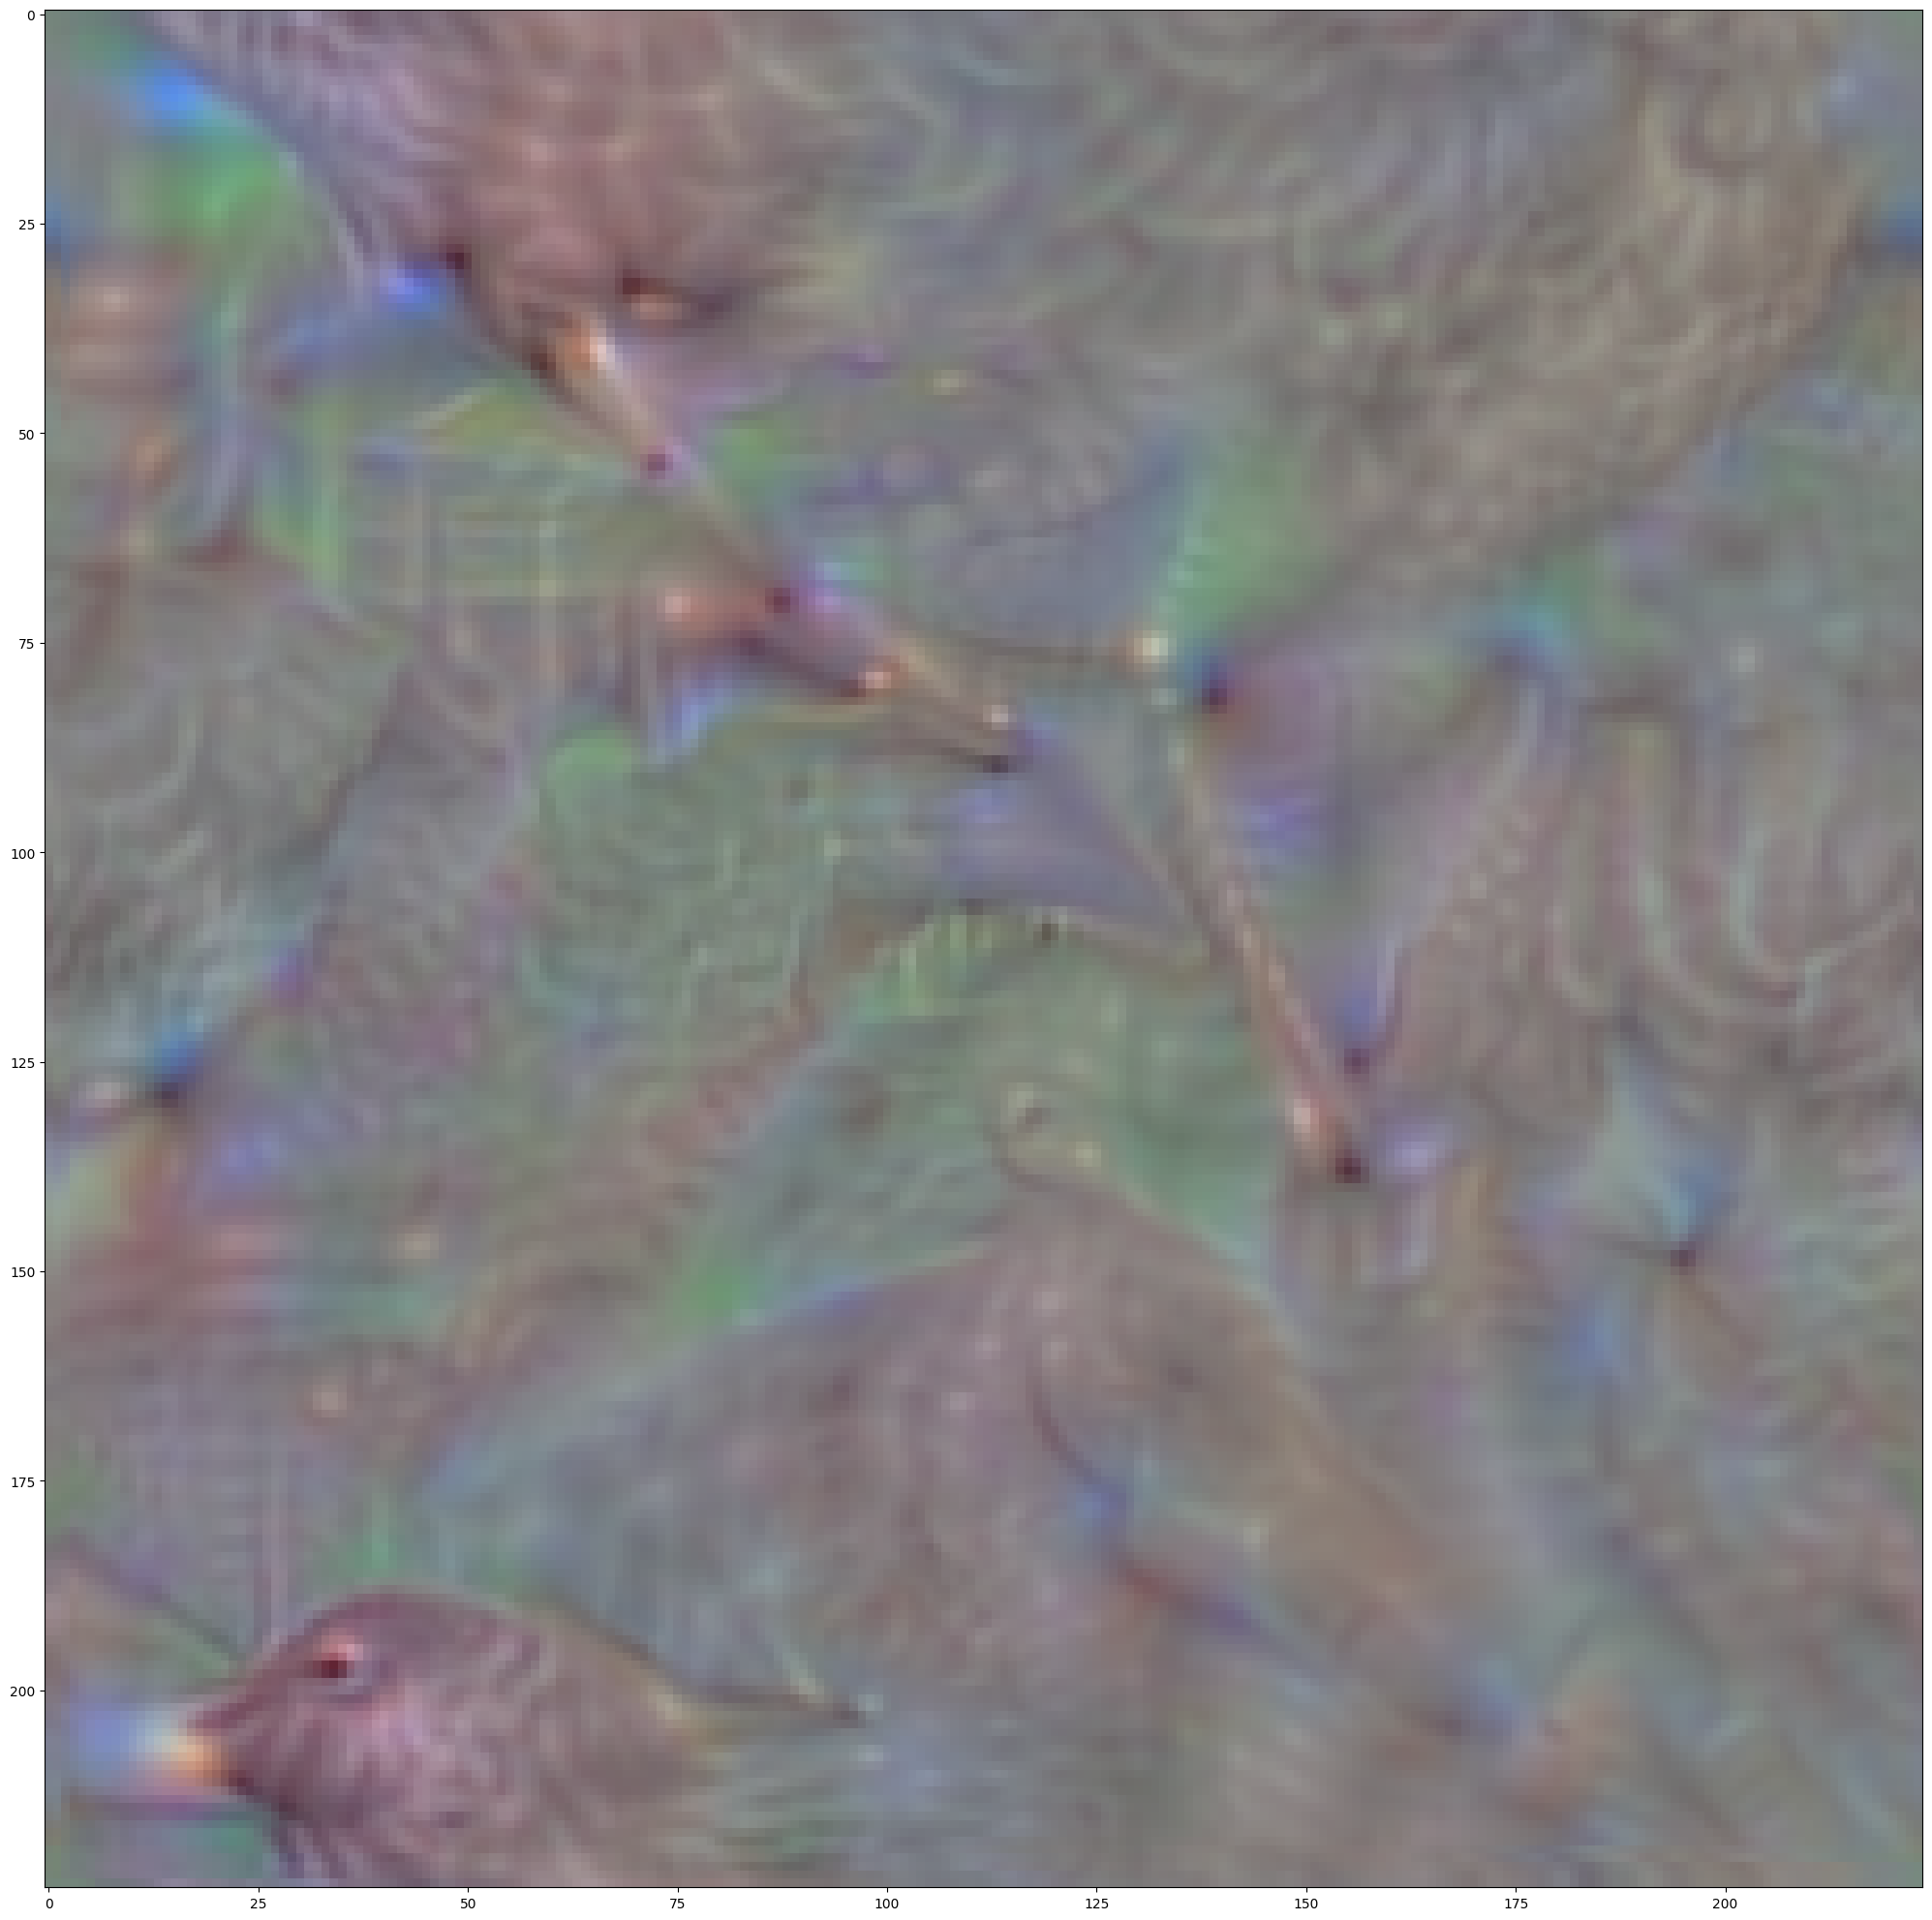

In [26]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 20

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()


**Assignment**: You might want to play with this, e.g. 385: Indian elephant, 2: great white shark, 555: fire truck

Other classes can be found at:
[ImageNet](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

<ipython-input-27-d19015e86ffd>:15: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[65.2204360961914]],	Regularization: [('TotalVariation2D', [4.634795665740967]), ('Norm', [38.15918731689453])]
Steps: 100	Scores: [[120.09872436523438]],	Regularization: [('TotalVariation2D', [5.231135368347168]), ('Norm', [38.13444900512695])]
Steps: 150	Scores: [[132.02049255371094]],	Regularization: [('TotalVariation2D', [5.668590545654297]), ('Norm', [38.14168930053711])]
Steps: 200	Scores: [[162.96383666992188]],	Regularization: [('TotalVariation2D', [5.9162187576293945]), ('Norm', [38.16862106323242])]


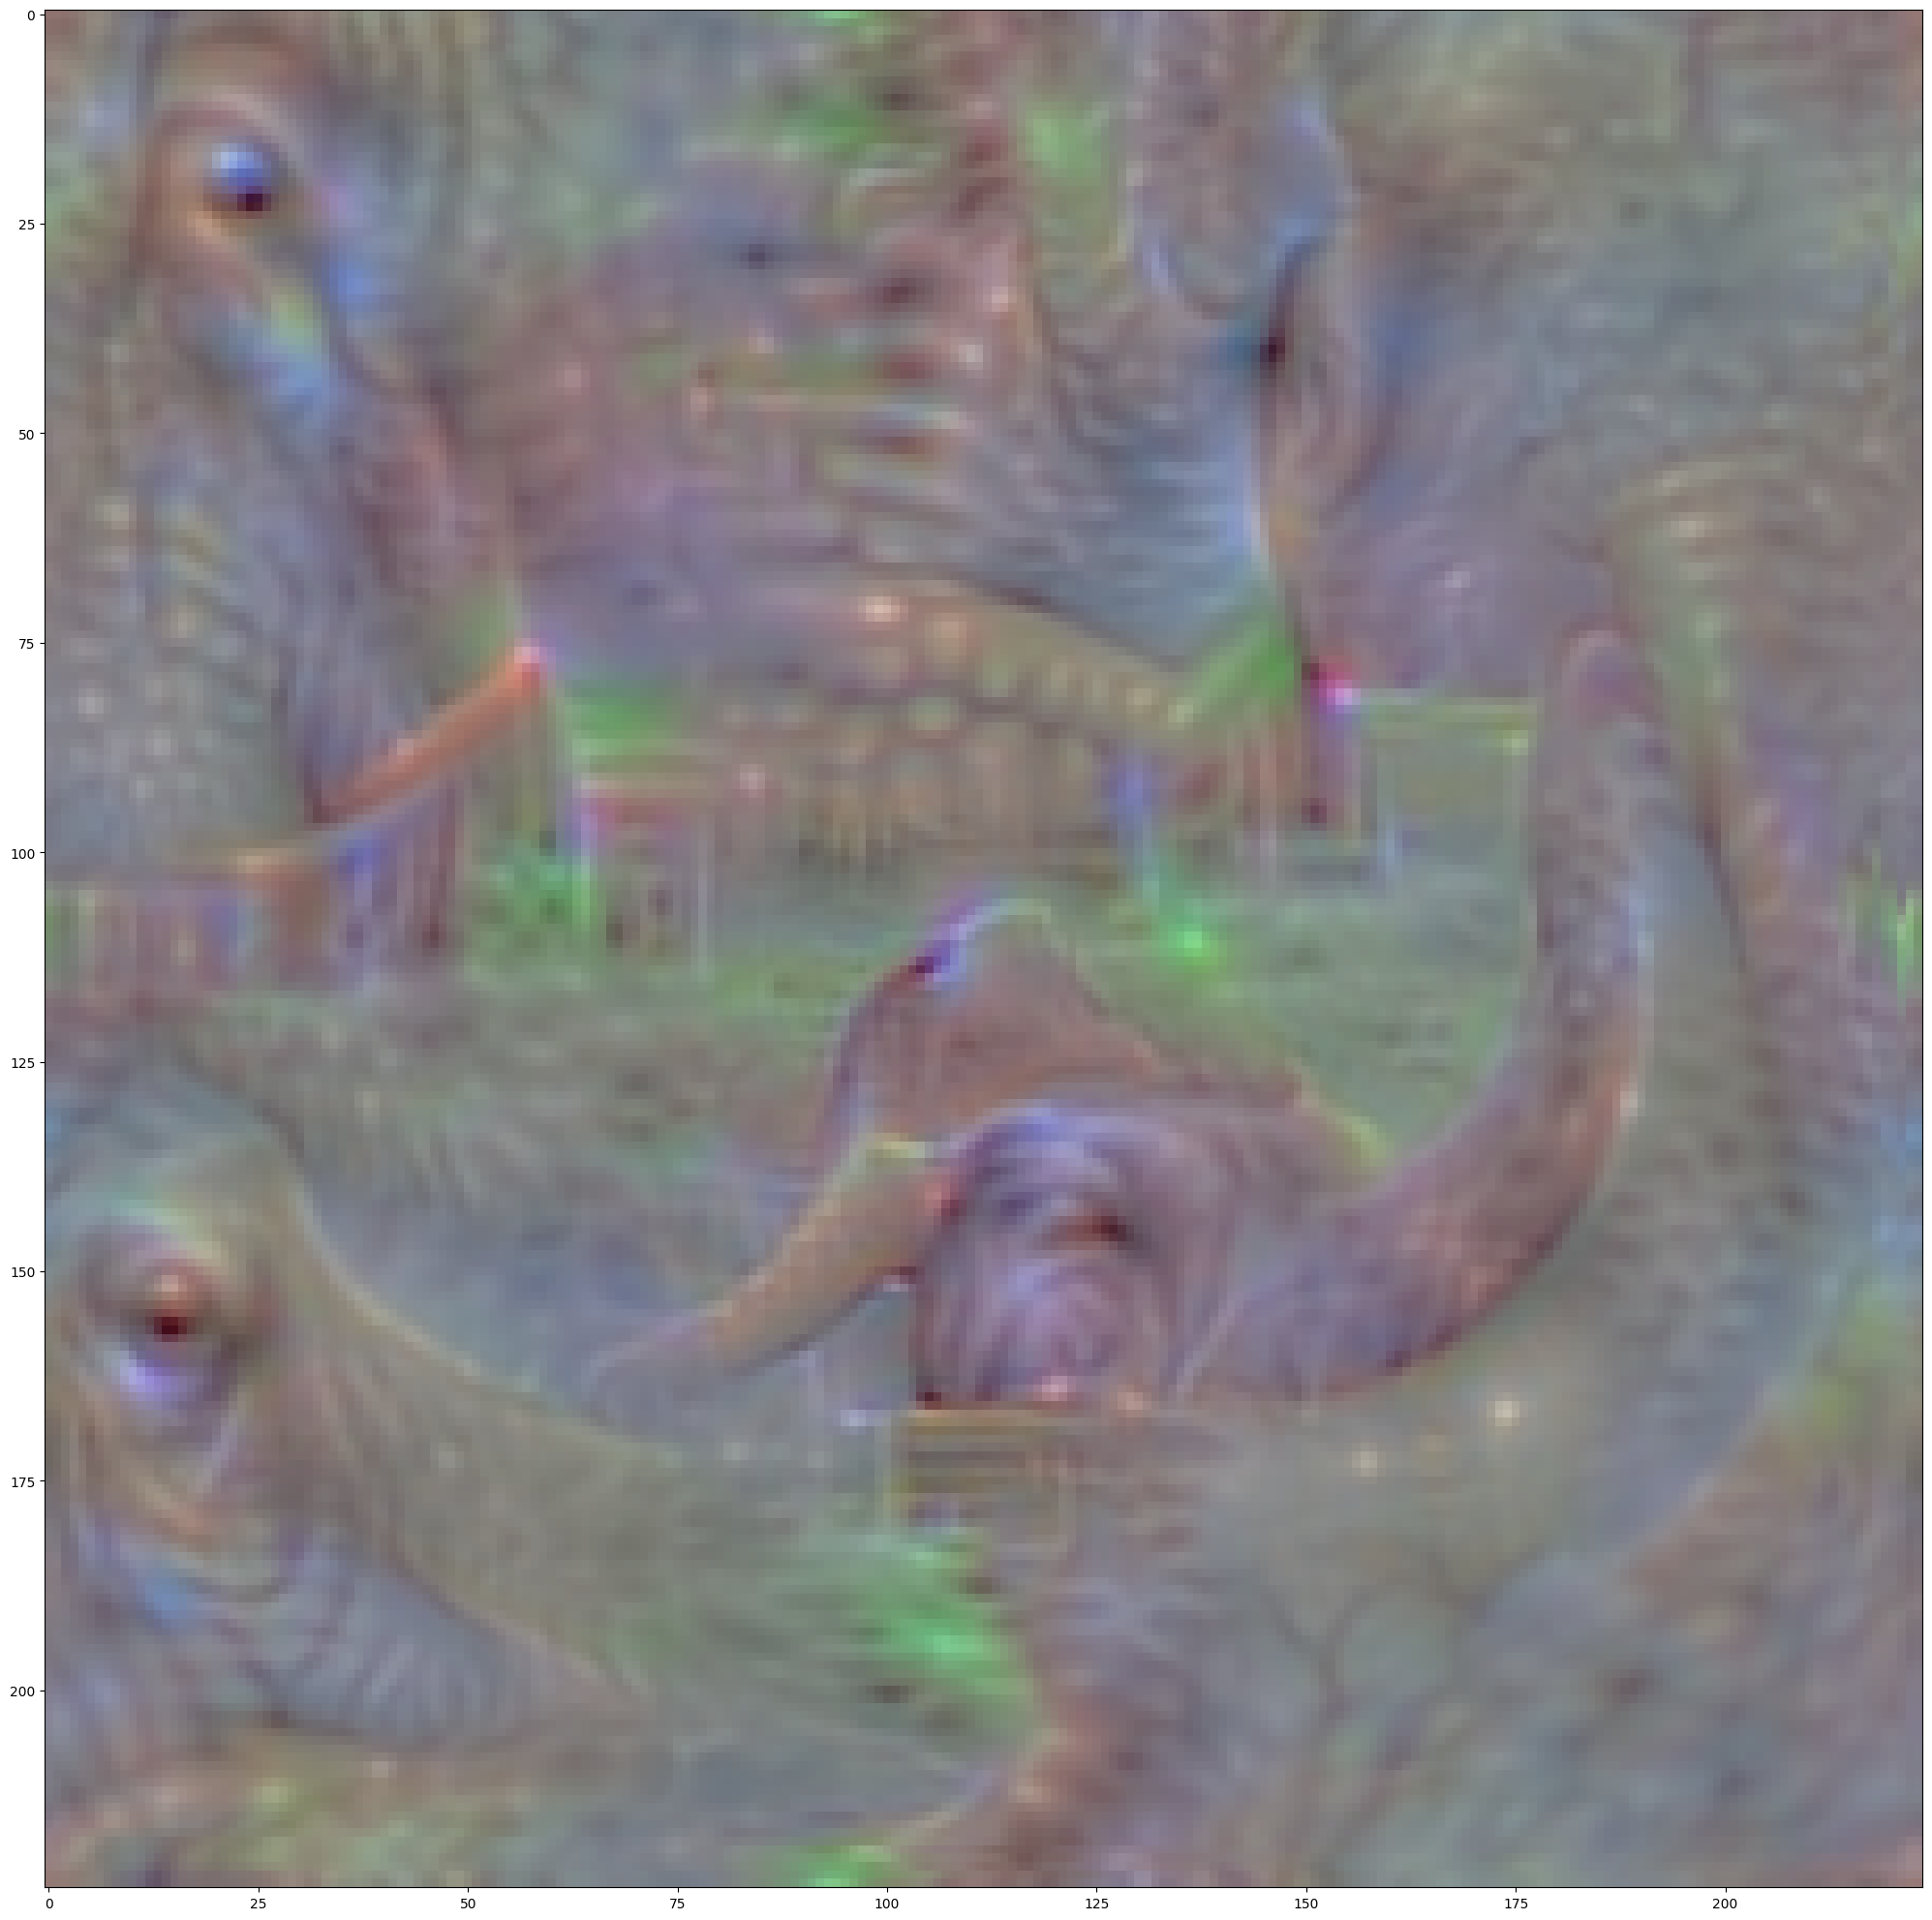

In [27]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 385 # 385: Indian elephant

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()

<ipython-input-28-f5ea5fc8c3d2>:15: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[51.149131774902344]],	Regularization: [('TotalVariation2D', [4.276669025421143]), ('Norm', [38.12537384033203])]
Steps: 100	Scores: [[114.61064910888672]],	Regularization: [('TotalVariation2D', [4.870194911956787]), ('Norm', [38.07896423339844])]
Steps: 150	Scores: [[160.77818298339844]],	Regularization: [('TotalVariation2D', [5.658057689666748]), ('Norm', [38.07664108276367])]
Steps: 200	Scores: [[152.30934143066406]],	Regularization: [('TotalVariation2D', [5.545133113861084]), ('Norm', [38.08371353149414])]


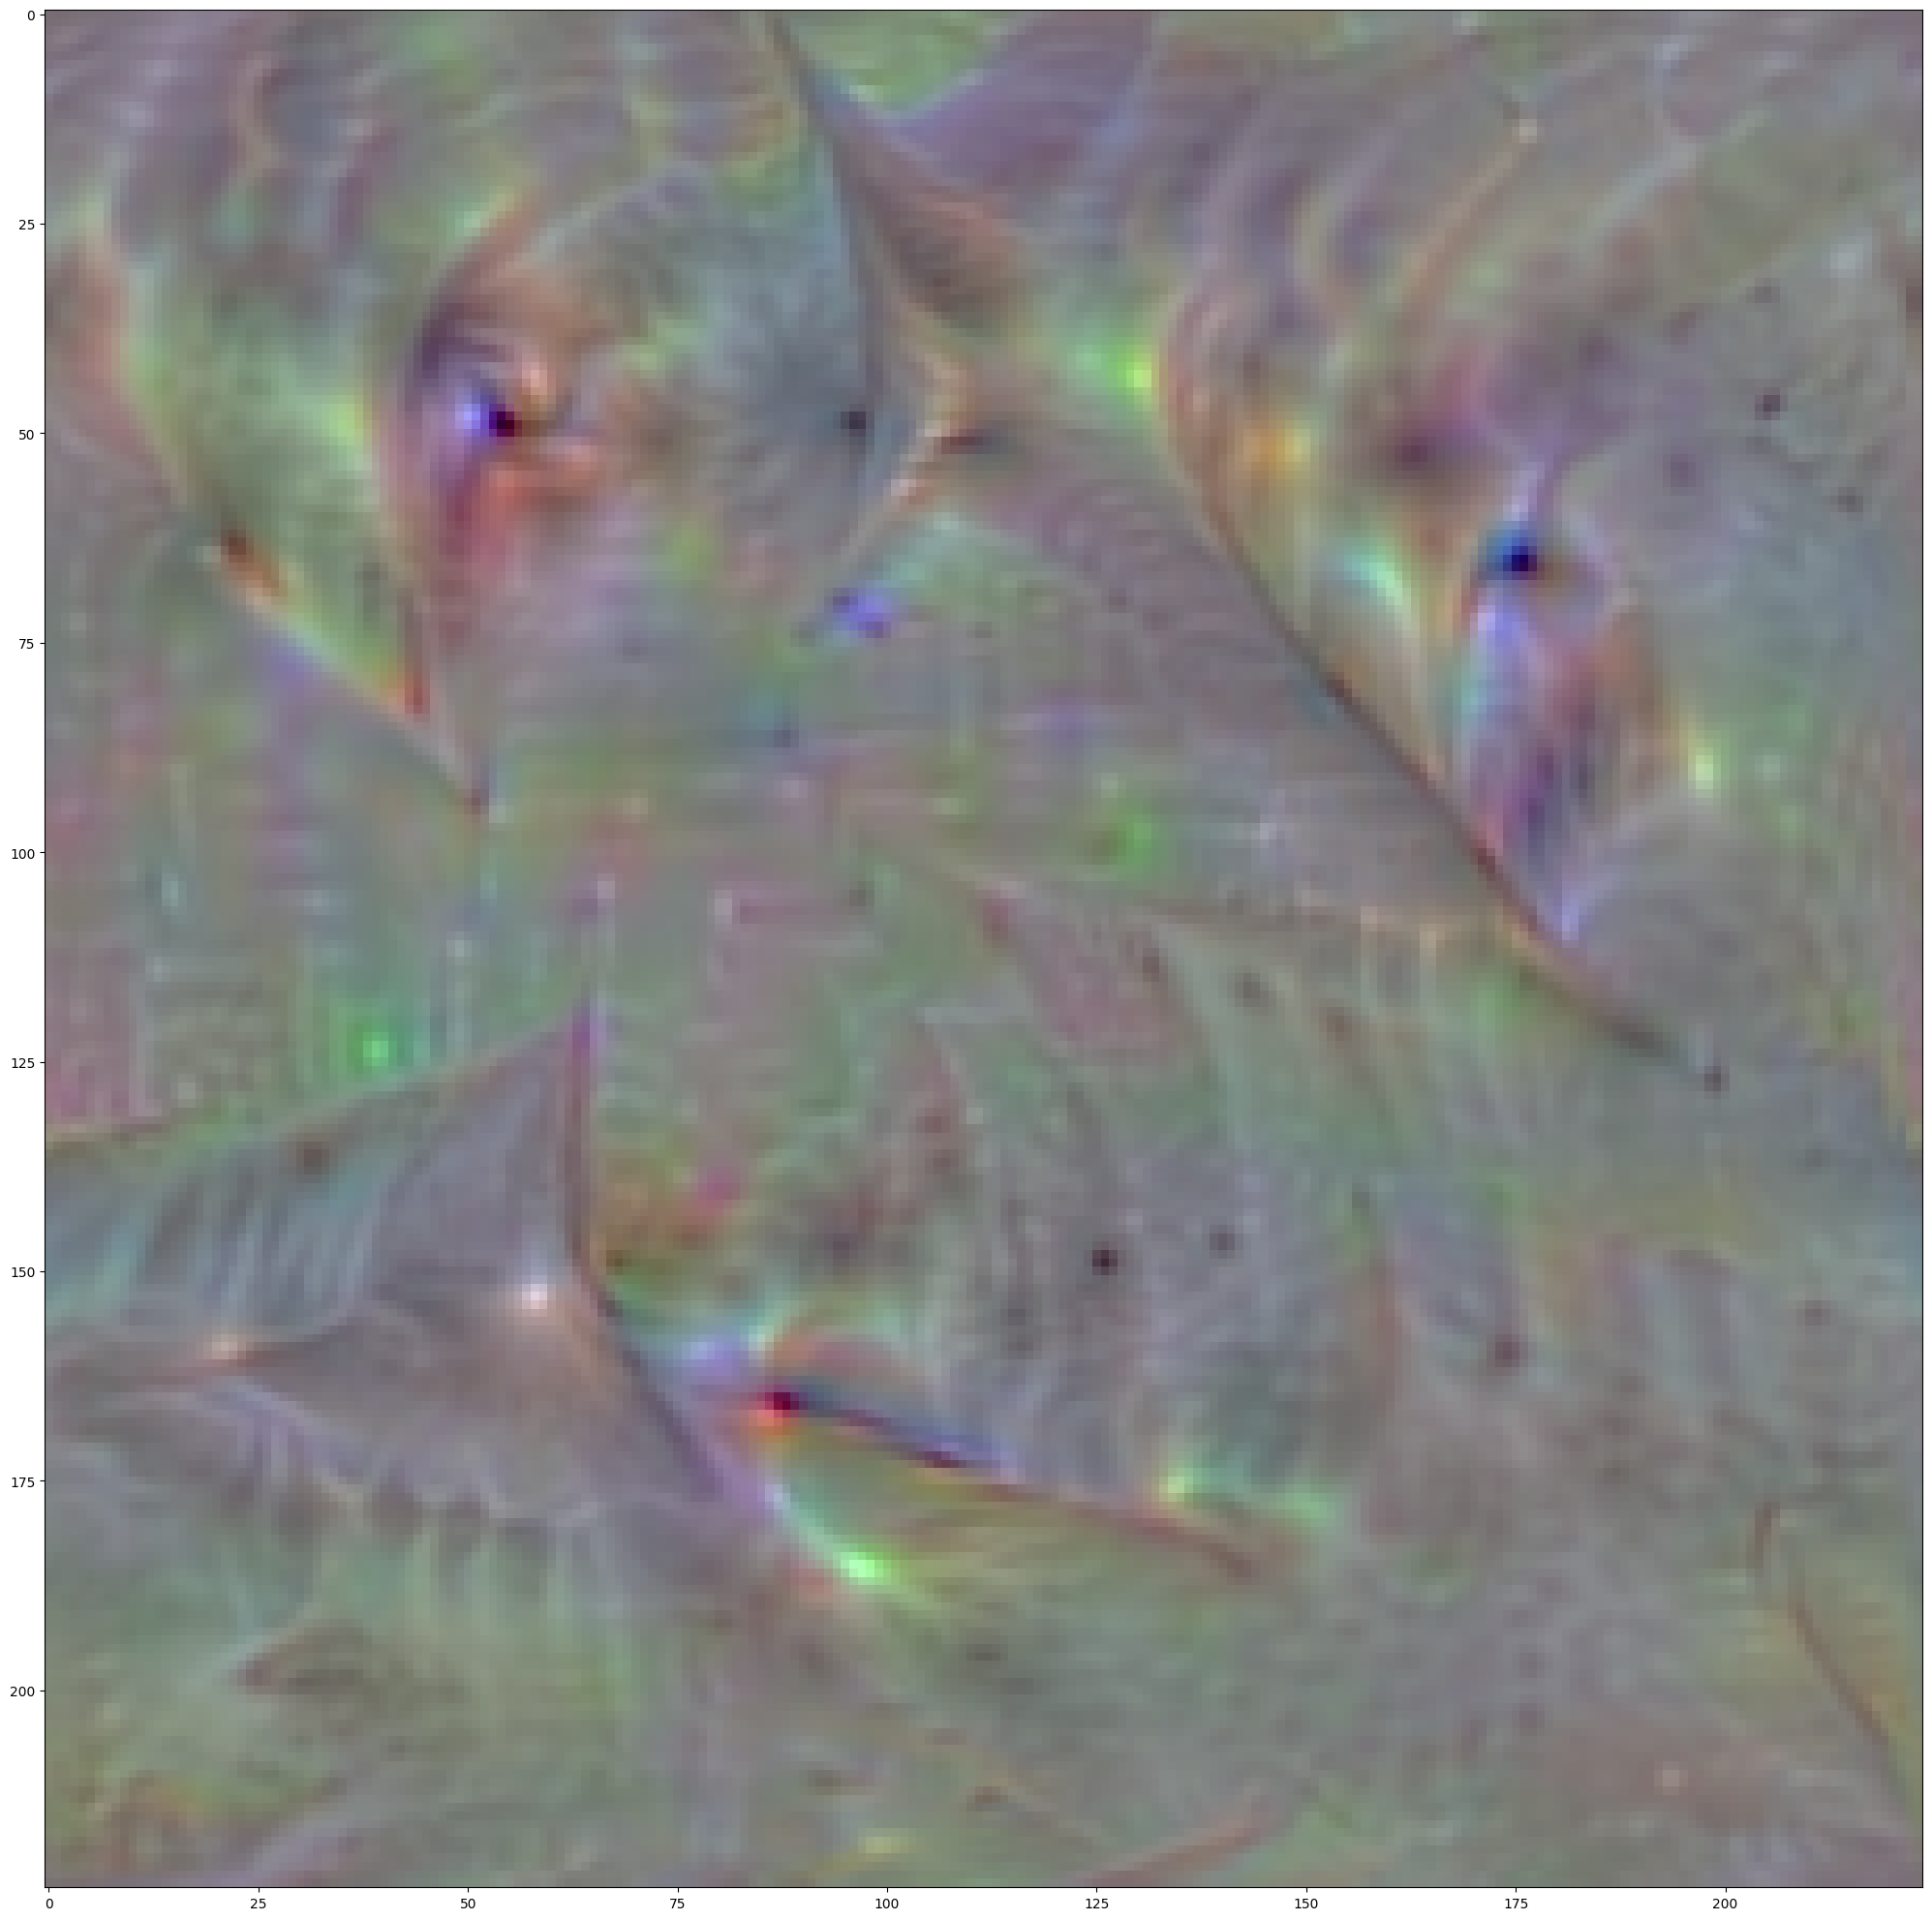

In [28]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 2 # 2: great white shark

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()

<ipython-input-29-9515901def90>:15: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[37.83940124511719]],	Regularization: [('TotalVariation2D', [4.070742607116699]), ('Norm', [38.16240310668945])]
Steps: 100	Scores: [[66.26420593261719]],	Regularization: [('TotalVariation2D', [3.8602817058563232]), ('Norm', [38.09645462036133])]
Steps: 150	Scores: [[84.39653778076172]],	Regularization: [('TotalVariation2D', [4.347789287567139]), ('Norm', [38.06262969970703])]
Steps: 200	Scores: [[94.87837219238281]],	Regularization: [('TotalVariation2D', [4.416611671447754]), ('Norm', [38.03020095825195])]


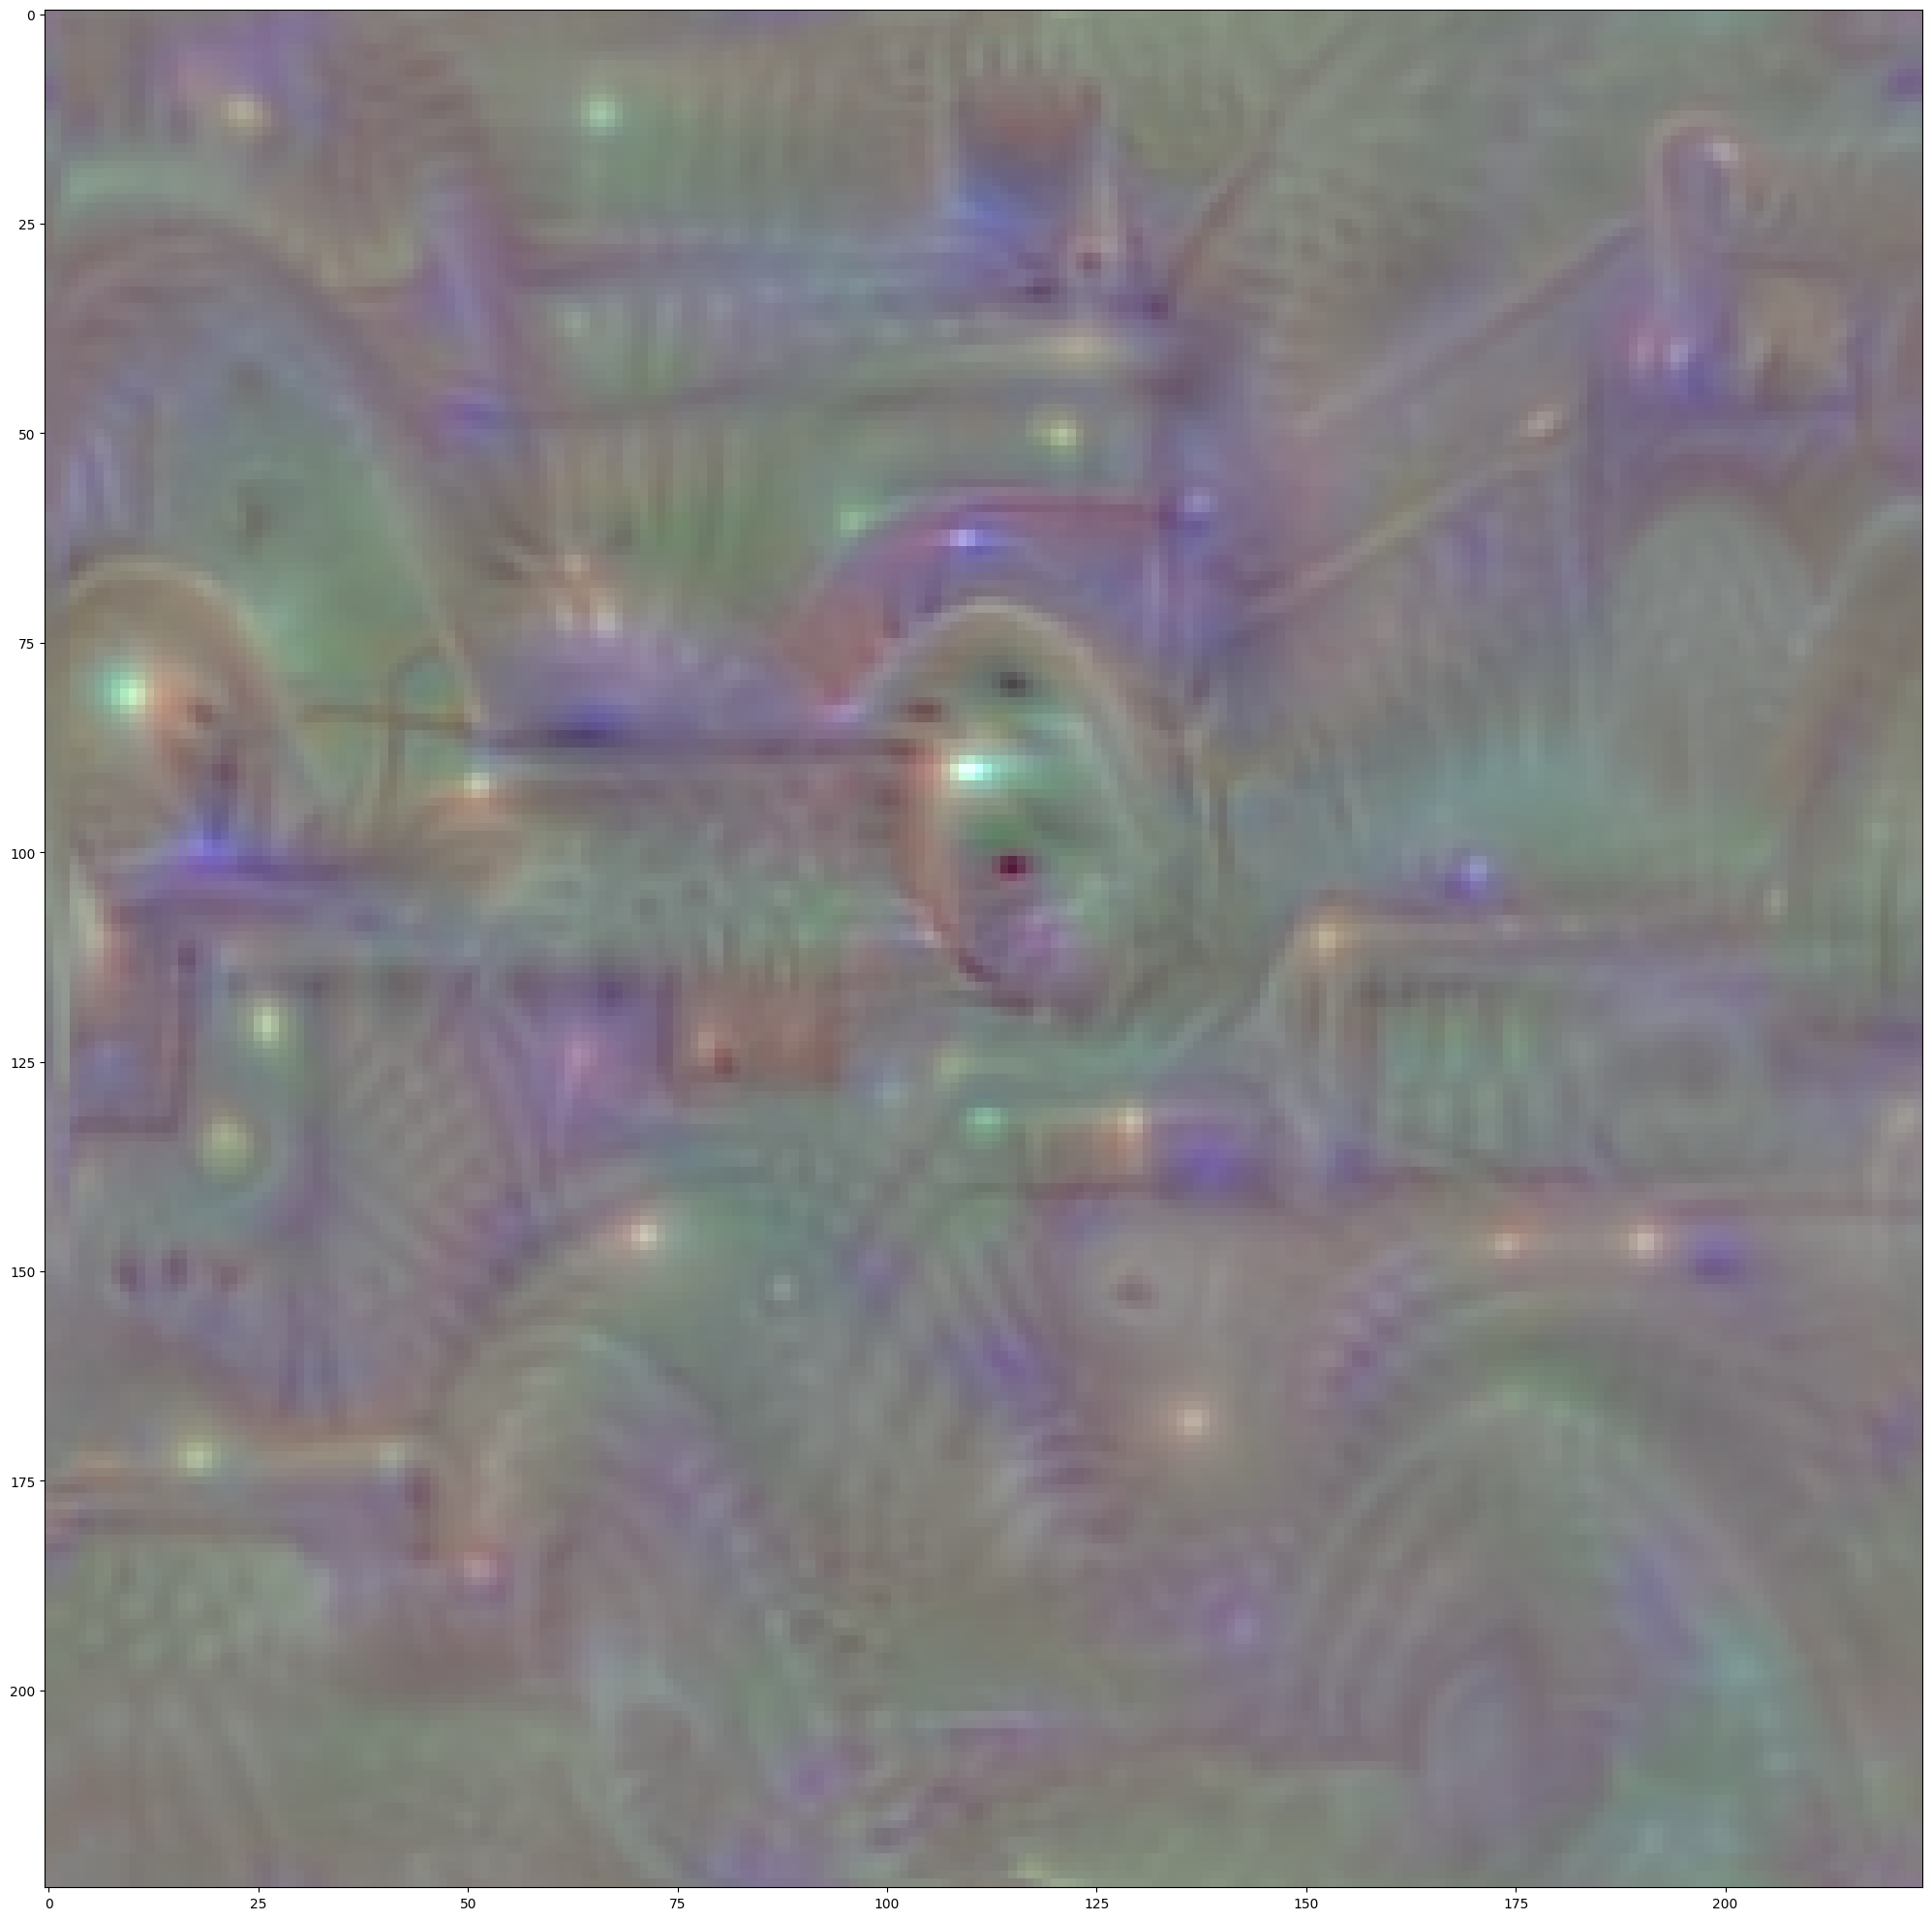

In [29]:
# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 555 # 555: fire truck

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()

**Assignment:** Generate the activation maximization image for  the same class, just as before, but for a network initialized randomly. What do you observe?

<ipython-input-30-444186ac37e6>:21: DeprecationWarning: Call to deprecated class PrintLogger. (Use `Progress` instead.) -- Deprecated since version 0.7.0.
  activation = activation_maximization(loss, callbacks=[Print(interval=50)])


Steps: 050	Scores: [[-0.19849684834480286]],	Regularization: [('TotalVariation2D', [3.3971164226531982]), ('Norm', [38.16798782348633])]
Steps: 100	Scores: [[-0.20063090324401855]],	Regularization: [('TotalVariation2D', [1.4433822631835938]), ('Norm', [38.07686233520508])]
Steps: 150	Scores: [[-0.19262707233428955]],	Regularization: [('TotalVariation2D', [0.8675503134727478]), ('Norm', [37.97969055175781])]
Steps: 200	Scores: [[-0.19670626521110535]],	Regularization: [('TotalVariation2D', [0.5867565274238586]), ('Norm', [37.88340759277344])]


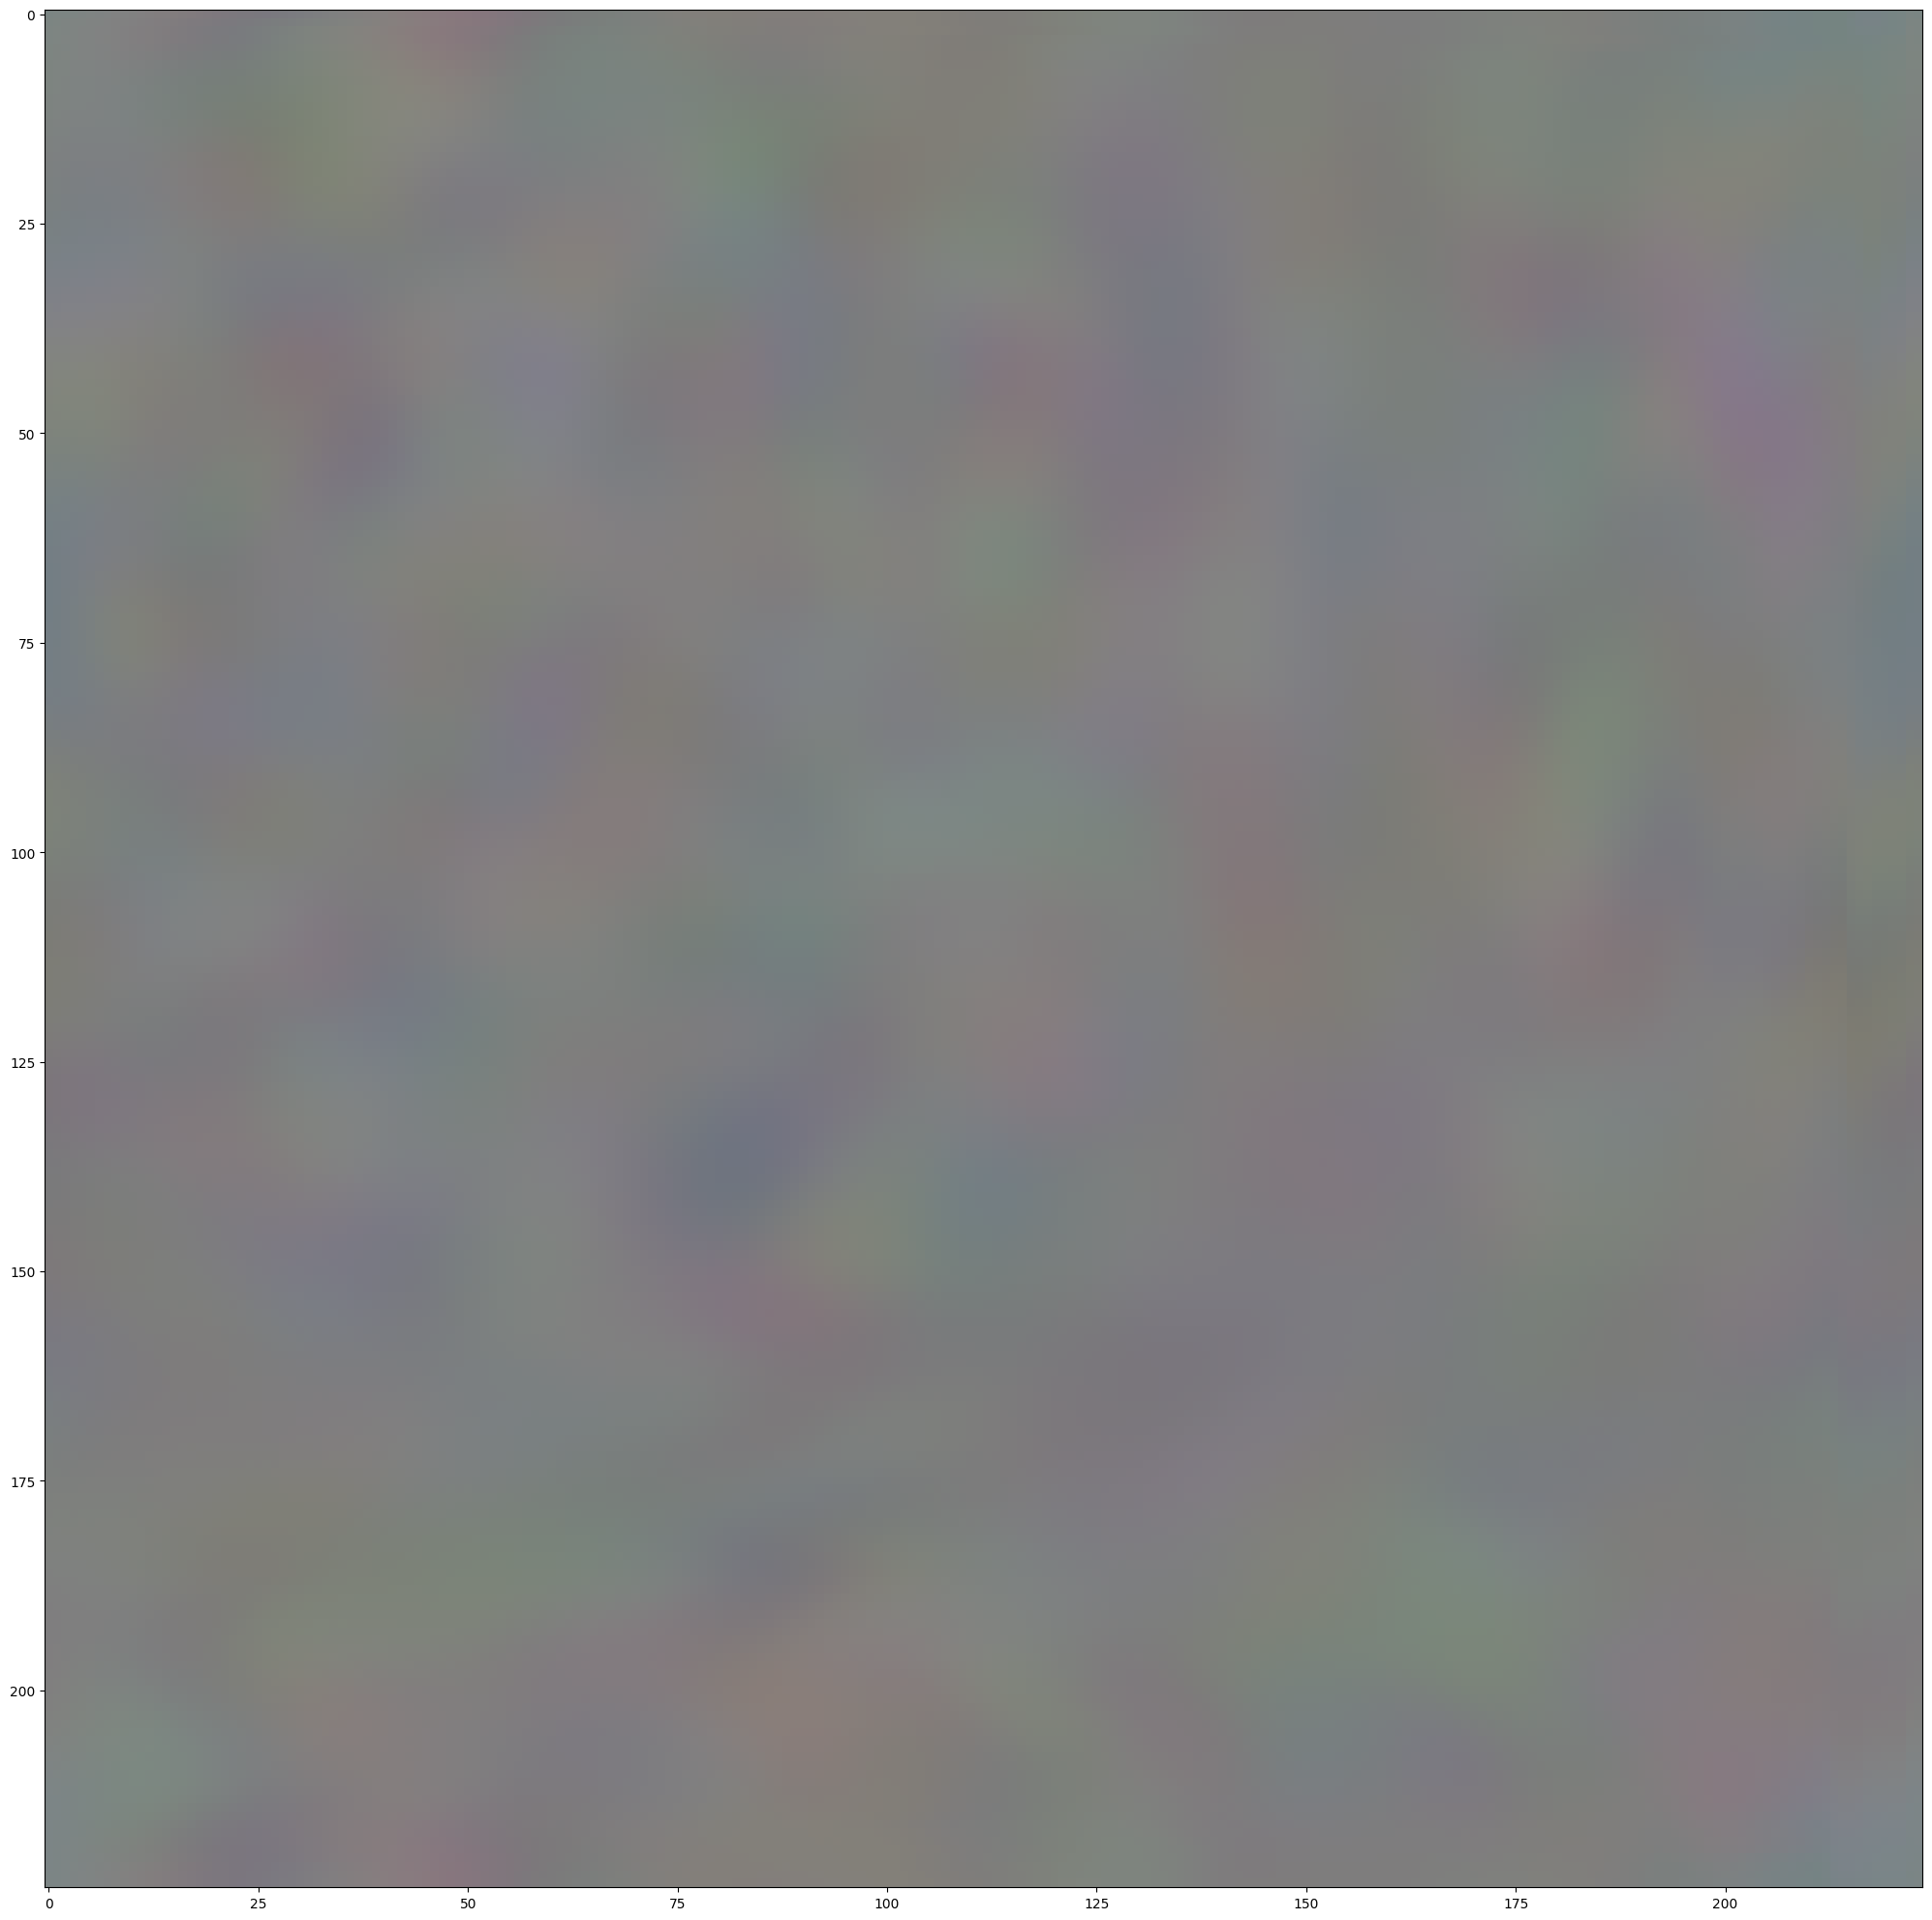

In [30]:
from tensorflow.keras.layers import Input

# Load the VGG16 model without weights
input_tensor = Input(shape=(224, 224, 3))
random_model = VGG16(input_tensor=input_tensor, weights=None)

# INDEX is the index of the class in the 1000-dimensional output vector
INDEX = 555 # 555: fire truck

from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(random_model,
                                                 model_modifier,
                                                 clone=False)

def loss(output):
    return output[:, INDEX]

from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss, callbacks=[Print(interval=50)])
generated_img = activation[0].numpy().astype(np.uint8)

plt.imshow(generated_img)
plt.tight_layout()

**Answer**: When generating the activation maximization image for the same class in a randomly initialized network, we observe that the generated image does not exhibit any meaningful or recognizable patterns.  
Unlike the image produced by a pre-trained network, the random network's image appears more like noise or abstract patterns, indicating that it doesn't "understand" the class as the pre-trained network does. This illustrates the importance of pre-trained weights in capturing meaningful features during training.